# Trabajo Práctico 2 - Aprendizaje Automatico 1
## Predicción de lluvia en Australia

### Integrantes: [Aranda, Maria Sol] - [Cicoria, Ignacio] - [Ricci, Guillermo]

### Año: 2025

# Contexto

El proyecto se basa en el análisis de las condiciones meteorológicas en Australia. El objetivo de este trabajo es predecir a las 23.59hs de cada dia, si al dia siguiente va a llover o no.
Para la construcción de un modelo que nos permita predecir este fenómeno, contamos con los datos de las condiciones meteorológicas por día de los últimos 10 años en las distintas localidades del país.
Gestionar adecuadamente estos datos nos permitirá desarrollar estrategias específicas para cada zona de Australia, y
asi obtener los mejores resultados de predicción para las precipitaciones por región.


### Variables del conjunto de datos  
| **Variable**         | **Descripción**                                                                 |
|----------------------|----------------------------------------------------------------------------------|
| **Date**             | Fecha de la observación meteorológica.                                           |
| **Location**         | Ciudad o estación meteorológica donde se registraron los datos.                  |
| **MinTemp**          | Temperatura mínima del día (°C).                                                 |
| **MaxTemp**          | Temperatura máxima del día (°C).                                                 |
| **Rainfall**         | Cantidad de lluvia caída ese día (mm).                                           |
| **Evaporation**      | Evaporación del agua (mm) registrada ese día.                                    |
| **Sunshine**         | Horas de sol registradas durante el día.                                         |
| **WindGustDir**      | Dirección del viento más fuerte del día (puntos cardinales, ej. N, SW).          |
| **WindGustSpeed**    | Velocidad del viento más fuerte (km/h).                                          |
| **WindDir9am**       | Dirección del viento a las 9 a.m.                                                |
| **WindDir3pm**       | Dirección del viento a las 3 p.m.                                                |
| **WindSpeed9am**     | Velocidad del viento a las 9 a.m. (km/h).                                        |
| **WindSpeed3pm**     | Velocidad del viento a las 3 p.m. (km/h).                                        |
| **Humidity9am**      | Humedad relativa (%) a las 9 a.m.                                                |
| **Humidity3pm**      | Humedad relativa (%) a las 3 p.m.                                                |
| **Pressure9am**      | Presión atmosférica (hPa) a las 9 a.m.                                           |
| **Pressure3pm**      | Presión atmosférica (hPa) a las 3 p.m.                                           |
| **Cloud9am**         | Cobertura de nubes a las 9 a.m. (escala de 0 a 9 octas).                         |
| **Cloud3pm**         | Cobertura de nubes a las 3 p.m. (escala de 0 a 9 octas).                         |
| **Temp9am**          | Temperatura a las 9 a.m. (°C).                                                   |
| **Temp3pm**          | Temperatura a las 3 p.m. (°C).                                                   |
| **RainToday**        | Indicador (Si/No) de si llovió ese día.                                 |
| **RainTomorrow**     | Indicador (Si/No) de si se espera lluvia al día siguiente (target de predicción).|


# Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import category_encoders as ce

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import ( confusion_matrix,classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, roc_auc_score
)

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")




# Carga del Dataset

Comenzamos con la carga del dataset **weatherAUS.csv** que contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no en la columna *‘RainTomorrow’*.

In [3]:
# Carga datos de dataset en dataframe
file_path= 'https://raw.githubusercontent.com/guillericci/AA1-TUIA-Aranda-Cicoria-Ricci/refs/heads/main/weatherAUS.csv'
df = pd.read_csv(file_path)

In [4]:
# Cargamos además las coordenadas de Australia
coord_aus = pd.read_csv('https://raw.githubusercontent.com/guillericci/AA1-TUIA-Aranda-Cicoria-Ricci/refs/heads/main/coordenadas_aus.csv')

# Analisis Exploratorio

Procedemos a obtener información general del dataset. Variables involucradas, cantidad de registros no nulos y tipos de datos de las mismas.

In [5]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

(145460, 23)

In [6]:
# Recuento de valores nulos por columna
nulos = df.isnull().sum().sort_values(ascending=False)
nulos_percent = (nulos / len(df)) * 100
nulos_df = pd.DataFrame({'Nulos': nulos, 'Porcentaje': nulos_percent})
print("\n Valores nulos por columna:")
print(nulos_df)


 Valores nulos por columna:
               Nulos  Porcentaje
Sunshine       69835   48.009762
Evaporation    62790   43.166506
Cloud3pm       59358   40.807095
Cloud9am       55888   38.421559
Pressure9am    15065   10.356799
Pressure3pm    15028   10.331363
WindDir9am     10566    7.263853
WindGustDir    10326    7.098859
WindGustSpeed  10263    7.055548
Humidity3pm     4507    3.098446
WindDir3pm      4228    2.906641
Temp3pm         3609    2.481094
RainTomorrow    3267    2.245978
Rainfall        3261    2.241853
RainToday       3261    2.241853
WindSpeed3pm    3062    2.105046
Humidity9am     2654    1.824557
WindSpeed9am    1767    1.214767
Temp9am         1767    1.214767
MinTemp         1485    1.020899
MaxTemp         1261    0.866905
Date               0    0.000000
Location           0    0.000000


Observamos que hay valores faltantes en las variables de nuestro dataset, por lo tanto deberemos tomar una decision de imputacion sobre los mismos. Lo analizaremos mas adelante.

In [7]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Procedemos a visualizar las medidas descriptivas asociadas a las variables
cuantitativas.

In [8]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


##Correlograma


Visualizamos la matriz de correlación para observar la relación lineal entre las variables explicativas.

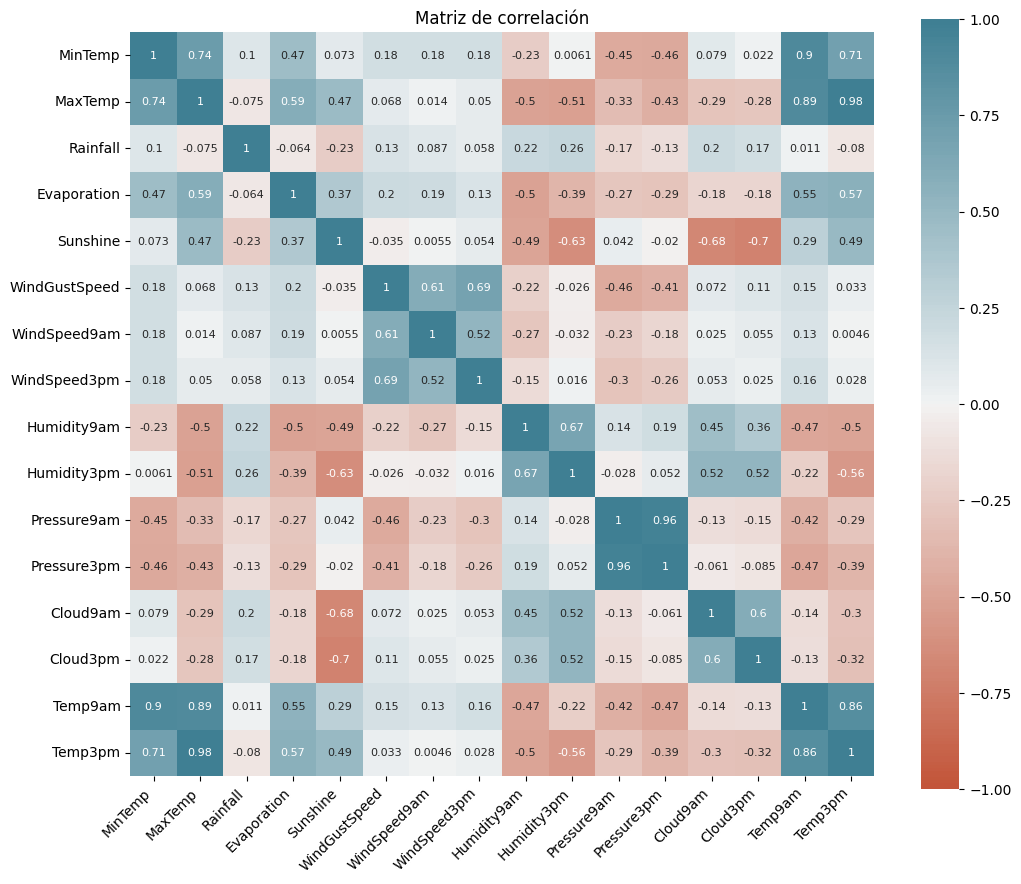

In [9]:
df_num = df.select_dtypes(include=['float64', 'int64'])
# Calcular la matriz de correlación
corr = df_num.corr()
# Crear una figura más grande
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de correlación')
plt.show()

Realizamos gráficos de dispersión sobre las variables que presentan una correlación mayor o igual a 0.7 .

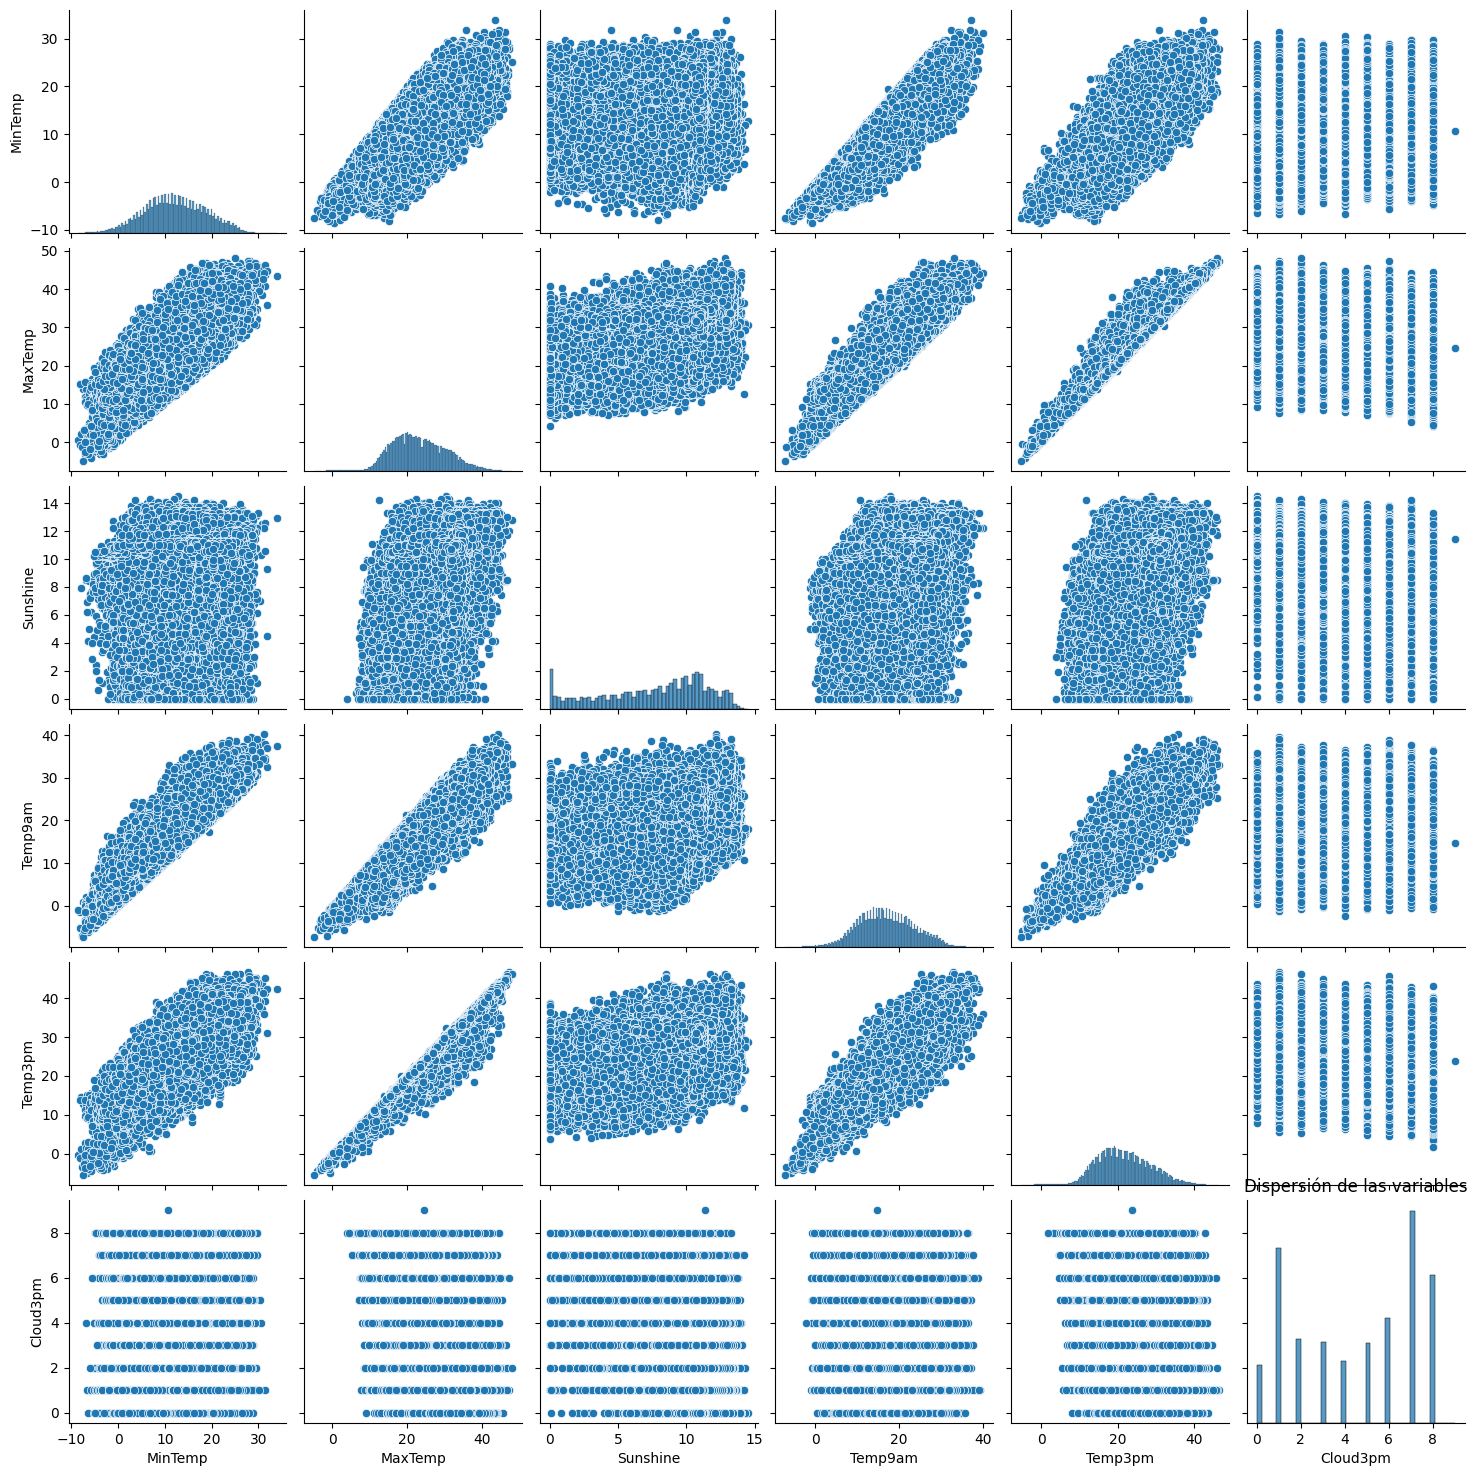

In [10]:
columnas = [
    "MinTemp", "MaxTemp", "Sunshine", "Temp9am", "Temp3pm", "Cloud3pm"
]

df_correlacion = df[columnas]
sns.pairplot(df_correlacion)
plt.title('Dispersión de las variables')
plt.show()

Procedemos a graficar la distribución de las variables categóricas.

In [11]:
# Columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
# Excluimos columnas con muchos valores únicos o irrelevantes para visualización categórica
cat_cols_plot = [col for col in cat_cols if col not in ['Date', 'Location', 'RainTomorrow']]

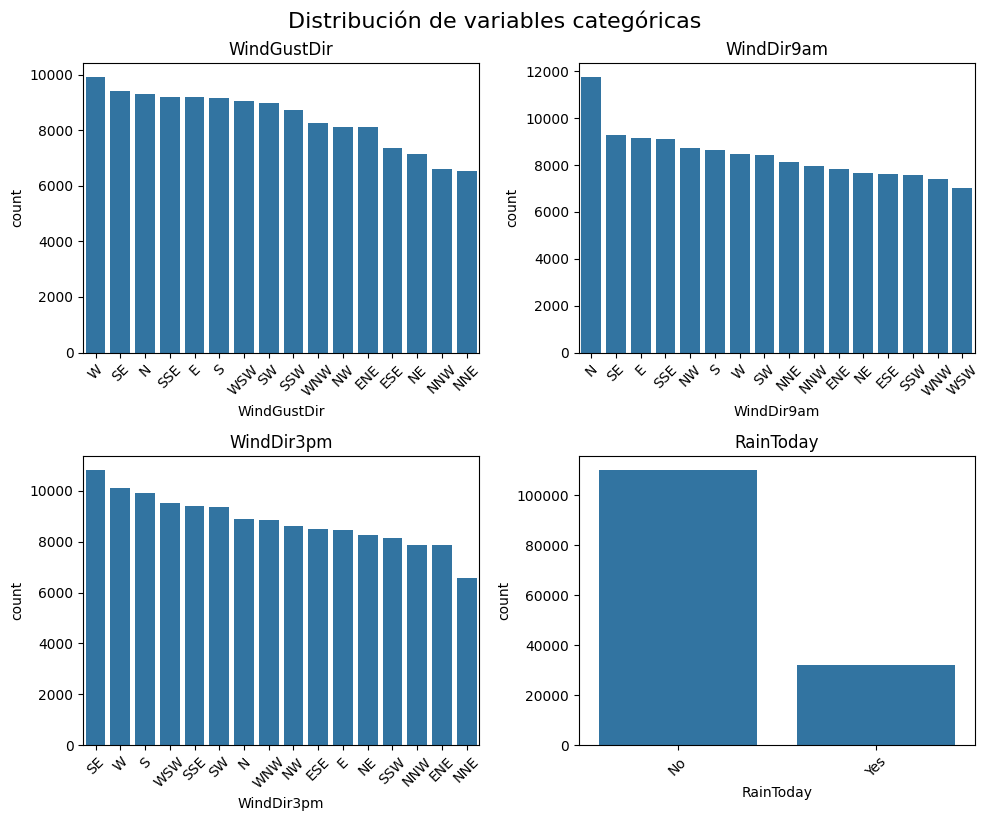

In [12]:
def plot_categorical_distributions(df, cols, cols_per_row=2):
    cat_vars = len(cols)
    rows = math.ceil(cat_vars / cols_per_row)

    plt.figure(figsize=(cols_per_row * 5, rows * 4))

    for i, col in enumerate(cols):
        plt.subplot(rows, cols_per_row, i + 1)
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(col)
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.suptitle('Distribución de variables categóricas', fontsize=16, y=1.02)
    plt.show()

plot_categorical_distributions(df, cat_cols_plot)

Procedemos a graficar las variables cuantitativas con relación a la variable target, para ver cómo varía su comportamiento respecto a ella.

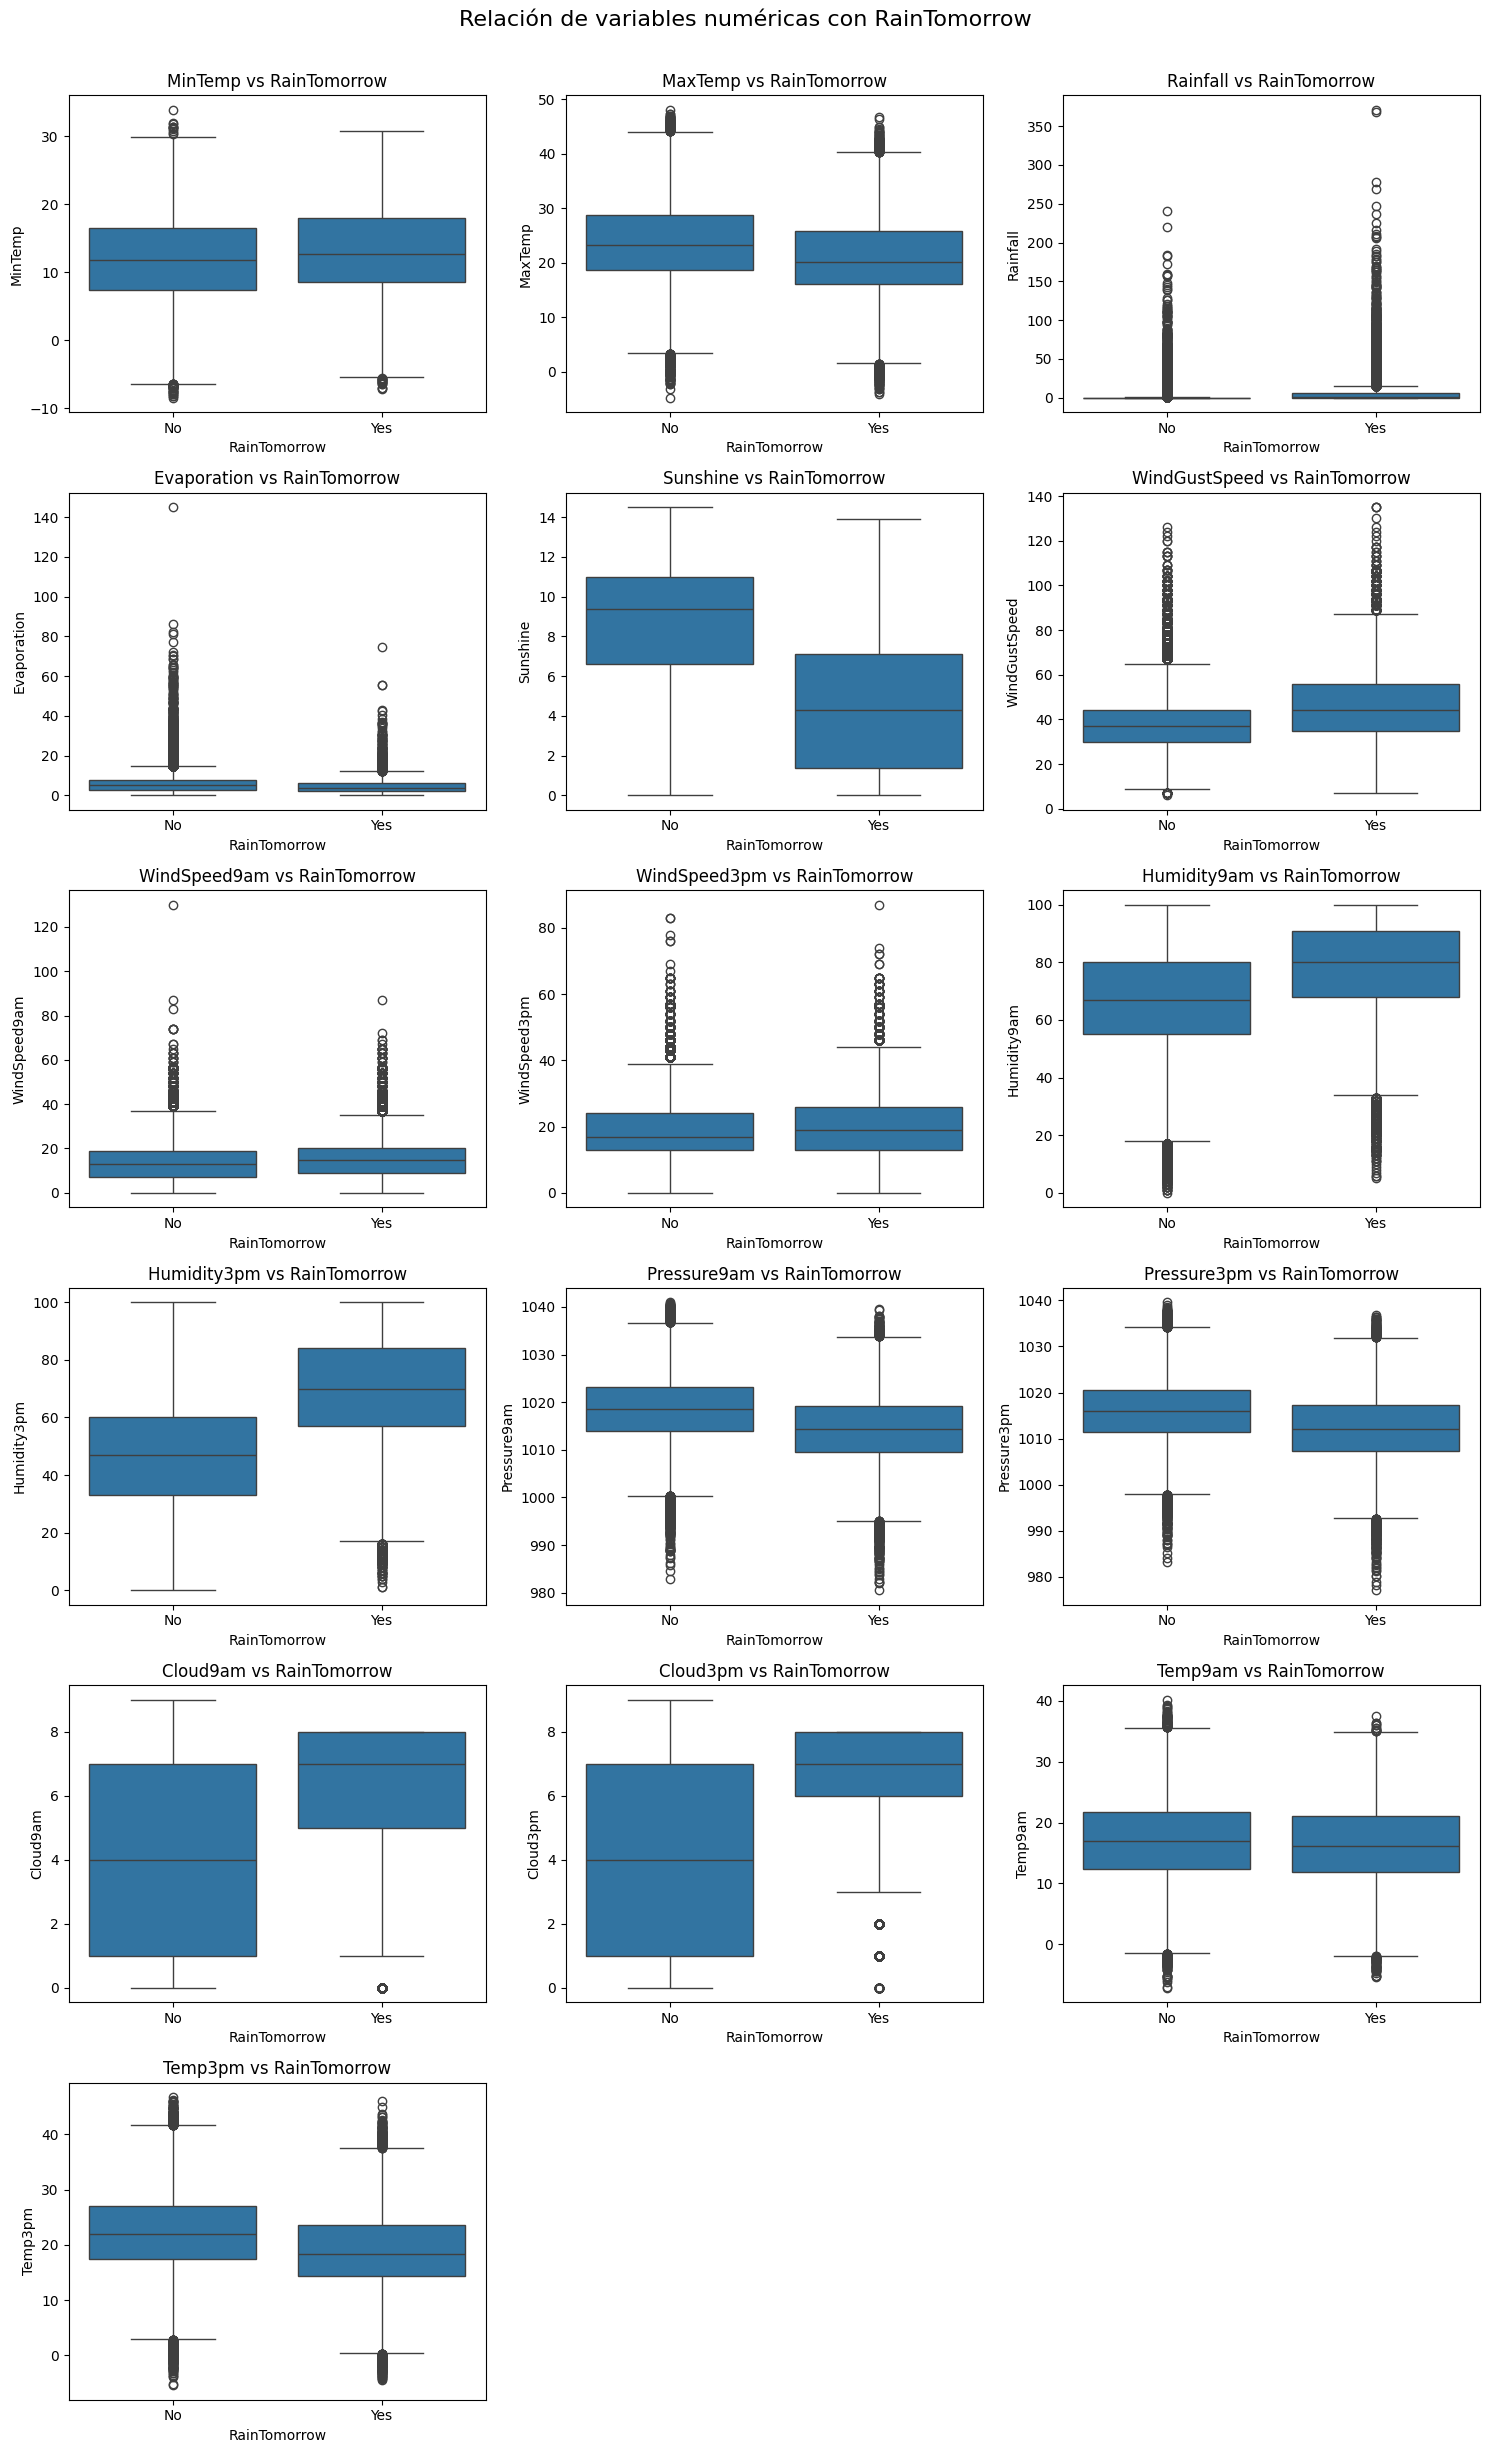

In [13]:
def plot_numeric_vs_target(df, num_cols, target, cols_per_row=3):
    import math
    num_vars = len(num_cols)
    rows = math.ceil(num_vars / cols_per_row)

    plt.figure(figsize=(cols_per_row * 5, rows * 4))

    for i, col in enumerate(num_cols):
        plt.subplot(rows, cols_per_row, i + 1)
        sns.boxplot(x=target, y=col, data=df)
        plt.title(f'{col} vs {target}')
        plt.tight_layout()

    plt.suptitle(f'Relación de variables numéricas con {target}', fontsize=16, y=1.02)
    plt.show()

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
plot_numeric_vs_target(df, num_cols, 'RainTomorrow')

De estas visualizaciones podemos deducir que las variable relativas a la *humedad*, la *presión* y las *horas de sol* parecen significativas a la hora de determinar si llueve o no al día siguiente.


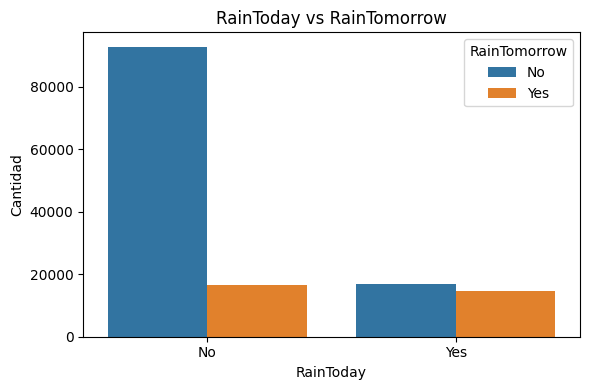

In [14]:
def plot_rain_today_vs_rain_tomorrow(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='RainToday', hue='RainTomorrow', data=df, order=df['RainToday'].value_counts().index)
    plt.title('RainToday vs RainTomorrow')
    plt.xlabel('RainToday')
    plt.ylabel('Cantidad')
    plt.legend(title='RainTomorrow')
    plt.tight_layout()
    plt.show()

plot_rain_today_vs_rain_tomorrow(df)

# Preprocesamiento de datos

## Segmentación de datos temporales

In [15]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

#Extraemos de 'Date' la fecha, el mes y el año.
df['mes'] = df['Date'].dt.month
df['anio'] = df['Date'].dt.year
df['fecha'] = df['Date'].dt.date

df.drop('Date', axis=1, inplace = True)

##Agrupamiento de ciudades por regiones con Clustering espacial - KMeans

Comenzando identificacndo los diferentes valores de la variables *Location*


In [16]:
# Visualizamos los diferentes valores en Location
print(df['Location'].unique())
print(f"Cantidad de ciudades en Australia:", len(df['Location'].unique()))

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
Cantidad de ciudades en Australia: 49


Añadimos la información de las coordenadas por ciudad a nuestro dataset.

In [17]:
# Merge de ciudades y coordenadas
df = df.merge(coord_aus, on='Location', how='left')

In [18]:
# Verificamos si hay ciudades sin coordenadas
faltantes = df[df['Latitude'].isna() | df['Longitude'].isna()]['Location'].unique()
print("Ciudades sin coordenadas después del merge:", faltantes)

Ciudades sin coordenadas después del merge: []


In [19]:
df.sample(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,mes,anio,fecha,Latitude,Longitude
130860,Hobart,9.2,17.7,0.0,1.0,3.6,NNW,39.0,N,NW,...,NaN,11.9,17.3,No,No,5,2011,2011-05-19,-42.882600,147.325700
35590,SydneyAirport,18.8,29.5,0.0,8.0,8.4,NE,54.0,NNE,NE,...,4.0,24.6,26.0,No,Yes,11,2014,2014-11-30,-33.939900,151.175300
134043,Launceston,10.4,16.4,2.6,NaN,NaN,SSW,37.0,NNW,S,...,NaN,11.8,15.7,Yes,No,10,2011,2011-10-09,-41.433333,147.133333
29657,Richmond,19.0,25.0,1.2,NaN,NaN,ESE,24.0,SSW,SE,...,8.0,19.9,24.0,Yes,No,1,2016,2016-01-24,-33.599500,150.742400
40202,Williamtown,12.6,26.5,0.0,4.0,9.0,SE,43.0,NW,SSE,...,5.0,20.6,20.5,No,No,10,2010,2010-10-27,-32.806300,151.843600


Nos disponemos a ubicar cada una de las localidades en el mapa para su mejor
visualización y comprensión.

In [26]:
# Eliminar duplicados para que no repita ciudades
ciudades_unicas = df[['Location', 'Latitude', 'Longitude']].drop_duplicates()

# Crear el scatter plot con Plotly
fig = px.scatter_geo(
    ciudades_unicas,
    lat='Latitude',
    lon='Longitude',
    text='Location',
    title='Distribución geográfica de ciudades en Australia',
    scope='world',
    projection='natural earth'
)
# Centrar y enfocar en Australia
fig.update_geos(
    center=dict(lat=-25, lon=135),
    lataxis_range=[-50, -10],  # Rango de latitudes para enfocarse
    lonaxis_range=[120, 185],  # Rango de longitudes
    showland=True, landcolor="LightGreen"
)

fig.update_traces(marker=dict(size=8, color='blue'))
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show()


In [27]:
X = ciudades_unicas[['Latitude', 'Longitude']].values

Luego de probar con distintos numeros de clusters, concluímos en que 9 es un número con resultados de agrupamientos óptimo según lo que podemos visualizar en el mapa.

In [28]:
# Aplicamos KMeans para 9 clusters
k = 9
modelo_kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
ciudades_unicas['RegionCluster'] = modelo_kmeans.fit_predict(X)

In [29]:
#Graficamos la clusterización elegida
fig = px.scatter_geo(
    ciudades_unicas,
    lat='Latitude',
    lon='Longitude',
    color='RegionCluster',
    text='Location',
    title='Clusters de ciudades australianas por región geográfica',
    projection='natural earth',
    color_discrete_sequence=px.colors.qualitative.Set2  # o Set3, Pastel1, etc.

)

fig.update_traces(marker=dict(size=8),textposition='top center')

# Centrar y enfocar en Australia
fig.update_geos(
    center=dict(lat=-25, lon=135),
    lataxis_range=[-50, -10],  # Rango de latitudes para enfocarse
    lonaxis_range=[120, 185],  # Rango de longitudes
    showland=True, landcolor="LightGreen"
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

Agregamos a nuestro dataset la columna RegionCluster y eliminamos Location, Latitud y Longitud.

In [30]:
df = df.merge(ciudades_unicas[['Location', 'RegionCluster']], on='Location', how='left')

In [31]:
df.drop(columns=['Latitude', 'Longitude', 'Location'], inplace=True)

## Division Train-Test

Antes de realizar la división procedemos a eliminar los registros inconsistentes de la variable target.

In [32]:
#Eliminamos nulos de la variable target
df = df.dropna(subset=['RainTomorrow'])

In [33]:
y = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['RainTomorrow'], axis=1)
# División estratificada (porque la clase puede estar desbalanceada)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Imputacion de valores faltantes

Dividimos las variables en númericas y categóricas.

In [34]:
# Columnas numéricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Columnas categóricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

Visualizamos los valores faltantes de cada variable numerica.

In [35]:
X_train[num_cols].isnull().sum()

MinTemp            513
MaxTemp            258
Rainfall          1131
Evaporation      48695
Sunshine         54344
WindGustSpeed     7440
WindSpeed9am      1082
WindSpeed3pm      2130
Humidity9am       1418
Humidity3pm       2897
Pressure9am      11287
Pressure3pm      11262
Cloud9am         42877
Cloud3pm         45669
Temp9am            735
Temp3pm           2203
dtype: int64

Procedemos a visualizar la distribución de las variables numéricas mediante histogramas.

In [36]:
def plot_numeric_distributions(df, cols, cols_per_row=3):
    num_vars = len(cols)
    rows = math.ceil(num_vars / cols_per_row)

    plt.figure(figsize=(cols_per_row * 5, rows * 4))

    for i, col in enumerate(cols):
        plt.subplot(rows, cols_per_row, i + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(col)
        plt.tight_layout()

    plt.suptitle('Distribución de variables numéricas', fontsize=16, y=1.02)
    plt.show()

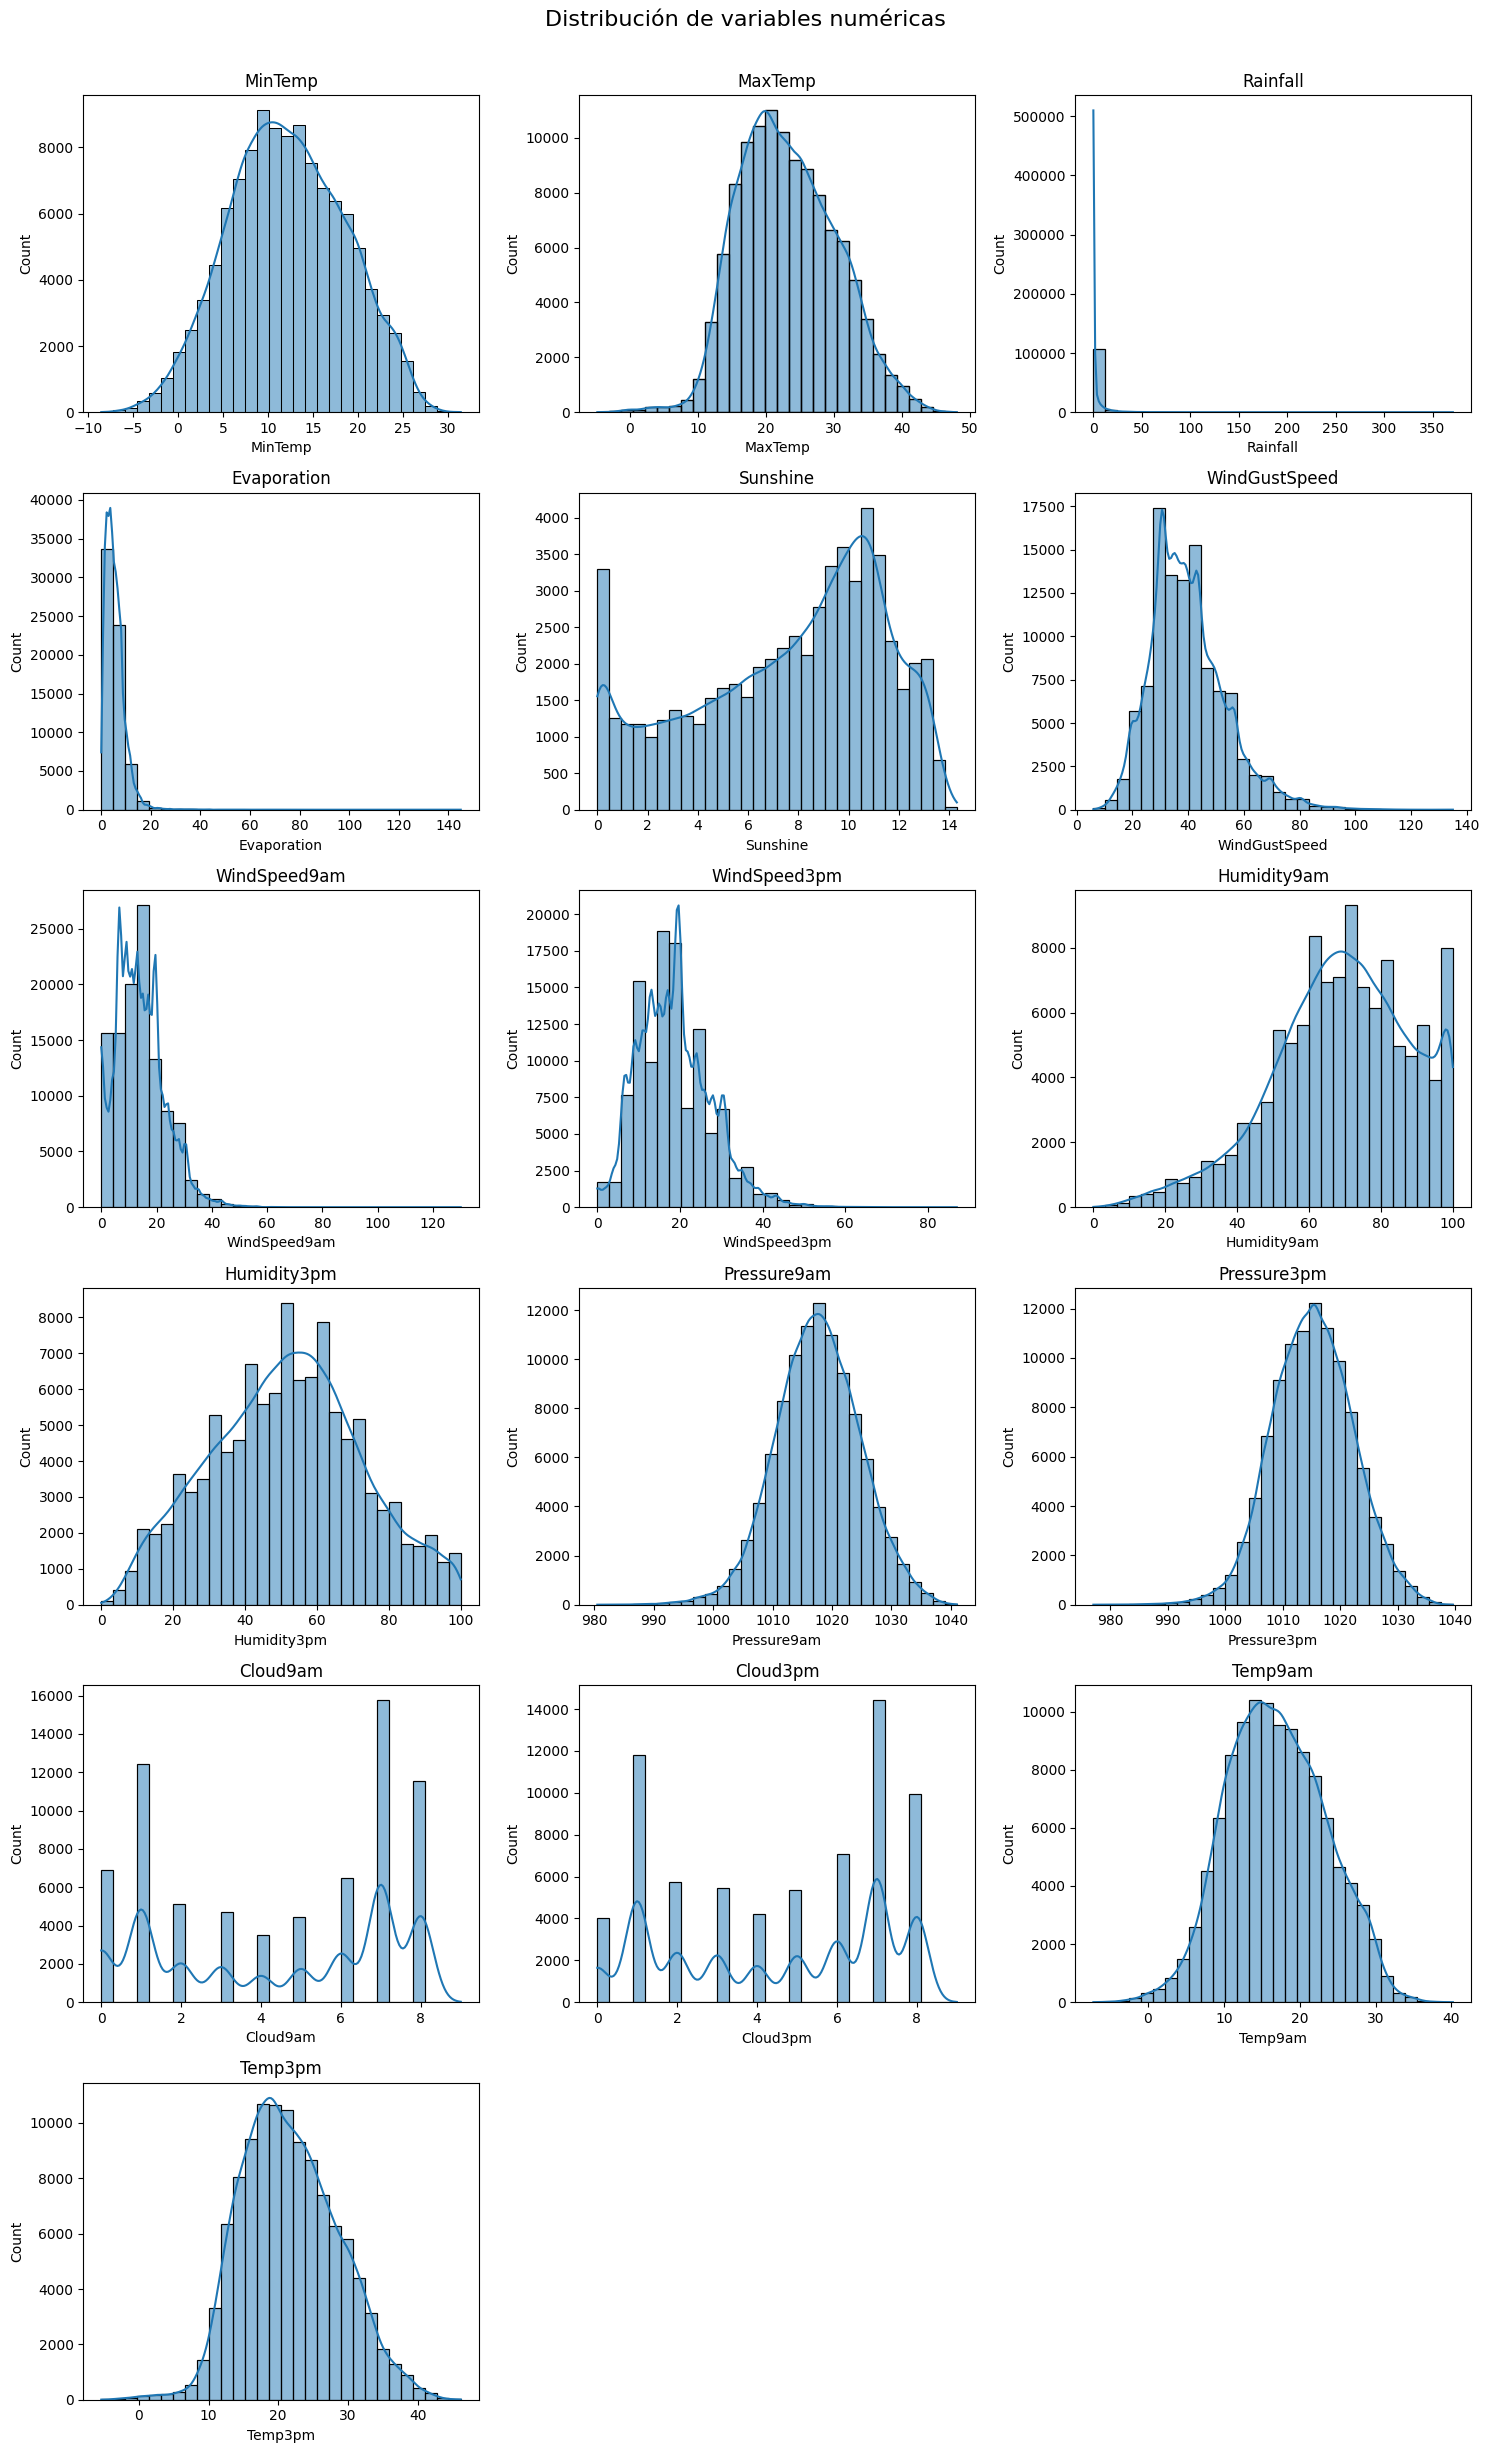

In [37]:
plot_numeric_distributions(X_train, num_cols)

Podemos visualizar que:


*   Las variables Rainfall y Evaporation presentan distribuciones altamente asimétricas, similares a una distribución exponencial, con una gran concentración de valores bajos.
*   Las variables MinTemp, MaxTemp, Temp9am, Temp3pm, Pressure9am, Pressure3pm
presentan distribuciones aproximadamente normal y simétricas.
* WindGustSpeed, WindSpeed9am, WindSpeed3pm presentan distribuciones sesgadas a la derecha.
* La variable Sunshine presenta una distribución bimodal o irregular, con una concentración en dos grupos principales que parecen corresponder a días soleados y nublados.
* Cloud9am, Cloud3pm son variables discretas.
* Humidity9am y Humidity3pm tienen distribuciones irregulares mas cercanas a bimodal y normal respectivamente.


   


Procedemos a imputar los valores faltantes de las variables numericas y continuas, a partir de la ***mediana*** ya que algunas distribuciones están sesgadas. Agrupamos por cluster(región) y por fecha.

In [38]:
# Columnas numéricas excepto las discretas
columnas_num_imputar =  [col for col in num_cols if col not in ['Cloud9am', 'Cloud3pm']]

# Diccionarios para guardar las medianas por grupo calculadas desde X_train
medianas_region_fecha = {}
medianas_region = {}

# Imputación jerárquica
for columna in columnas_num_imputar:
    # IMPUTACIÓN EN X_TRAIN
    # 1. Por RegionCluster + fecha
    X_train[columna] = X_train[columna].fillna(
        X_train.groupby(['RegionCluster', 'fecha'])[columna].transform('median')
    )

    # 2. Por RegionCluster (si sigue habiendo nulos)
    X_train[columna] = X_train[columna].fillna(
        X_train.groupby('RegionCluster')[columna].transform('median')
    )

    # CALCULAR LAS MEDIANAS EN X_TRAIN
    # Para luego usar en imputación de X_test
    medianas_region_fecha[columna] = X_train.groupby(['RegionCluster', 'fecha'])[columna].median()
    medianas_region[columna] = X_train.groupby('RegionCluster')[columna].median()

    # IMPUTACIÓN EN X_TEST
    def imputar_test(row):
        if pd.isna(row[columna]):
            clave1 = (row['RegionCluster'], row['fecha'])
            if clave1 in medianas_region_fecha[columna]:
                return medianas_region_fecha[columna][clave1]
            elif row['RegionCluster'] in medianas_region[columna]:
                return medianas_region[columna][row['RegionCluster']]
            else:
                return np.nan  # si no hay mediana para ese grupo
        else:
            return row[columna]

    X_test[columna] = X_test.apply(imputar_test, axis=1)

X_train[num_cols].isnull().sum()

MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am         42877
Cloud3pm         45669
Temp9am              0
Temp3pm              0
dtype: int64

Imputamos los valores faltantes de las variables categoricas y discretas a partir de la ***moda***. Agrupamos por cluster(región) y por fecha.


In [39]:
print("Variables antes de la imputacion: ")
X_train[cat_cols].isnull().sum()

Variables antes de la imputacion: 


WindGustDir    7485
WindDir9am     8055
WindDir3pm     3066
RainToday      1131
fecha             0
dtype: int64

In [40]:
# Función para calcular modas y hacer imputación eficiente
def imputar_categoricas(X_train, X_test, columnas_cat_imputar):
    def moda_segura(x):
        moda = x.mode()
        if not moda.empty:
            return moda.iloc[0]
        else:
            return np.nan

    X_train = X_train.copy()
    X_test = X_test.copy()

    for col in columnas_cat_imputar:
        # Moda global
        moda_global = moda_segura(X_train[col])

        # Modas por (fecha, RegionCluster)
        modas_fecha_cluster = (
            X_train.groupby(['fecha', 'RegionCluster'])[col]
            .agg(moda_segura)
            .rename('moda_fecha_cluster')
            .reset_index()
        )

        # Modas por RegionCluster
        modas_cluster = (
            X_train.groupby('RegionCluster')[col]
            .agg(moda_segura)
            .rename('moda_cluster')
            .reset_index()
        )

        # Imputación en X_train

        X_train = X_train.merge(modas_fecha_cluster, how='left', on=['fecha', 'RegionCluster'])
        X_train = X_train.merge(modas_cluster, how='left', on='RegionCluster')

        X_train[col] = X_train[col].fillna(X_train['moda_fecha_cluster'])
        X_train[col] = X_train[col].fillna(X_train['moda_cluster'])
        X_train[col] = X_train[col].fillna(moda_global)

        X_train.drop(columns=['moda_fecha_cluster', 'moda_cluster'], inplace=True)

        # Imputación en X_test

        X_test = X_test.merge(modas_fecha_cluster, how='left', on=['fecha', 'RegionCluster'])
        X_test = X_test.merge(modas_cluster, how='left', on='RegionCluster')

        X_test[col] = X_test[col].fillna(X_test['moda_fecha_cluster'])
        X_test[col] = X_test[col].fillna(X_test['moda_cluster'])
        X_test[col] = X_test[col].fillna(moda_global)

        X_test.drop(columns=['moda_fecha_cluster', 'moda_cluster'], inplace=True)

    return X_train, X_test

# Columnas categóricas a imputar
columnas_cat_imputar = cat_cols + ['Cloud9am', 'Cloud3pm']

# Ejecutar imputación
X_train, X_test = imputar_categoricas(X_train, X_test, columnas_cat_imputar)

# Mostrar resultados
print("Valores faltantes en X_train luego de la imputación categórica:")
print(X_train[columnas_cat_imputar].isnull().sum())

print("\nValores faltantes en X_test luego de la imputación categórica:")
print(X_test[columnas_cat_imputar].isnull().sum())

Valores faltantes en X_train luego de la imputación categórica:
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
fecha          0
Cloud9am       0
Cloud3pm       0
dtype: int64

Valores faltantes en X_test luego de la imputación categórica:
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
fecha          0
Cloud9am       0
Cloud3pm       0
dtype: int64


## Tratamiento de Outliers


Procederemos a imputar todos lo valores que sean físicamente imposibles o que se encuentren por fuera de los máximos y mínimos valores históricos registrados.

In [41]:
intervals = {
    'MinTemp': [-23, 50.7],
    'MaxTemp': [-23, 50.7],
    'Rainfall': [0, 907],
    'Evaporation': [0, 100],
    'Sunshine': [0, 16],
    'WindGustSpeed': [0, 408],
    'WindSpeed9am': [0, 408],
    'WindSpeed3pm': [0, 408],
    'Humidity9am': [0, 100],
    'Humidity3pm': [0, 100],
    'Pressure9am': [870, 1045],
    'Pressure3pm': [870, 1045],
    'Temp9am': [-23, 50.7],
    'Temp3pm': [-23, 50.7]
}

def cap_outliers_with_median(X, intervals, ref_data=None):
    """
    Imputa valores fuera de los límites usando la mediana.

    Parámetros:
    - X: DataFrame a imputar (X_train o X_test).
    - intervals: diccionario con los límites por variable.
    - ref_data: DataFrame para calcular la mediana (por ejemplo, X_train). Si es None, se usa X.
    """
    if ref_data is None:
        ref_data = X

    X_imputed = X.copy()

    for col, (low, high) in intervals.items():
        median = ref_data[col].median()
        X_imputed[col + '_cap'] = np.where(
            X[col] > high, median,
            np.where(X[col] < low, median, X[col])
        )

    return X_imputed

# Imputar train (usa sus propias medianas)
X_train_imputed = cap_outliers_with_median(X_train, intervals)

# Imputar test usando medianas de train
X_test_imputed = cap_outliers_with_median(X_test, intervals, ref_data=X_train)


Procedemos a visualizar la distribución y presencia de valores atípicos en las variables numéricas mediante un gráfico de boxplot.

In [42]:
def plot_boxplots(x, cols, cols_per_row=3):
    num_vars = len(cols)
    rows = math.ceil(num_vars / cols_per_row)

    plt.figure(figsize=(cols_per_row * 5, rows * 4))

    for i, col in enumerate(cols):
        plt.subplot(rows, cols_per_row, i + 1)
        sns.boxplot(x=x[col])
        plt.title(col)
        plt.tight_layout()

    plt.suptitle('Boxplots de variables numéricas', fontsize=16, y=1.02)
    plt.show()


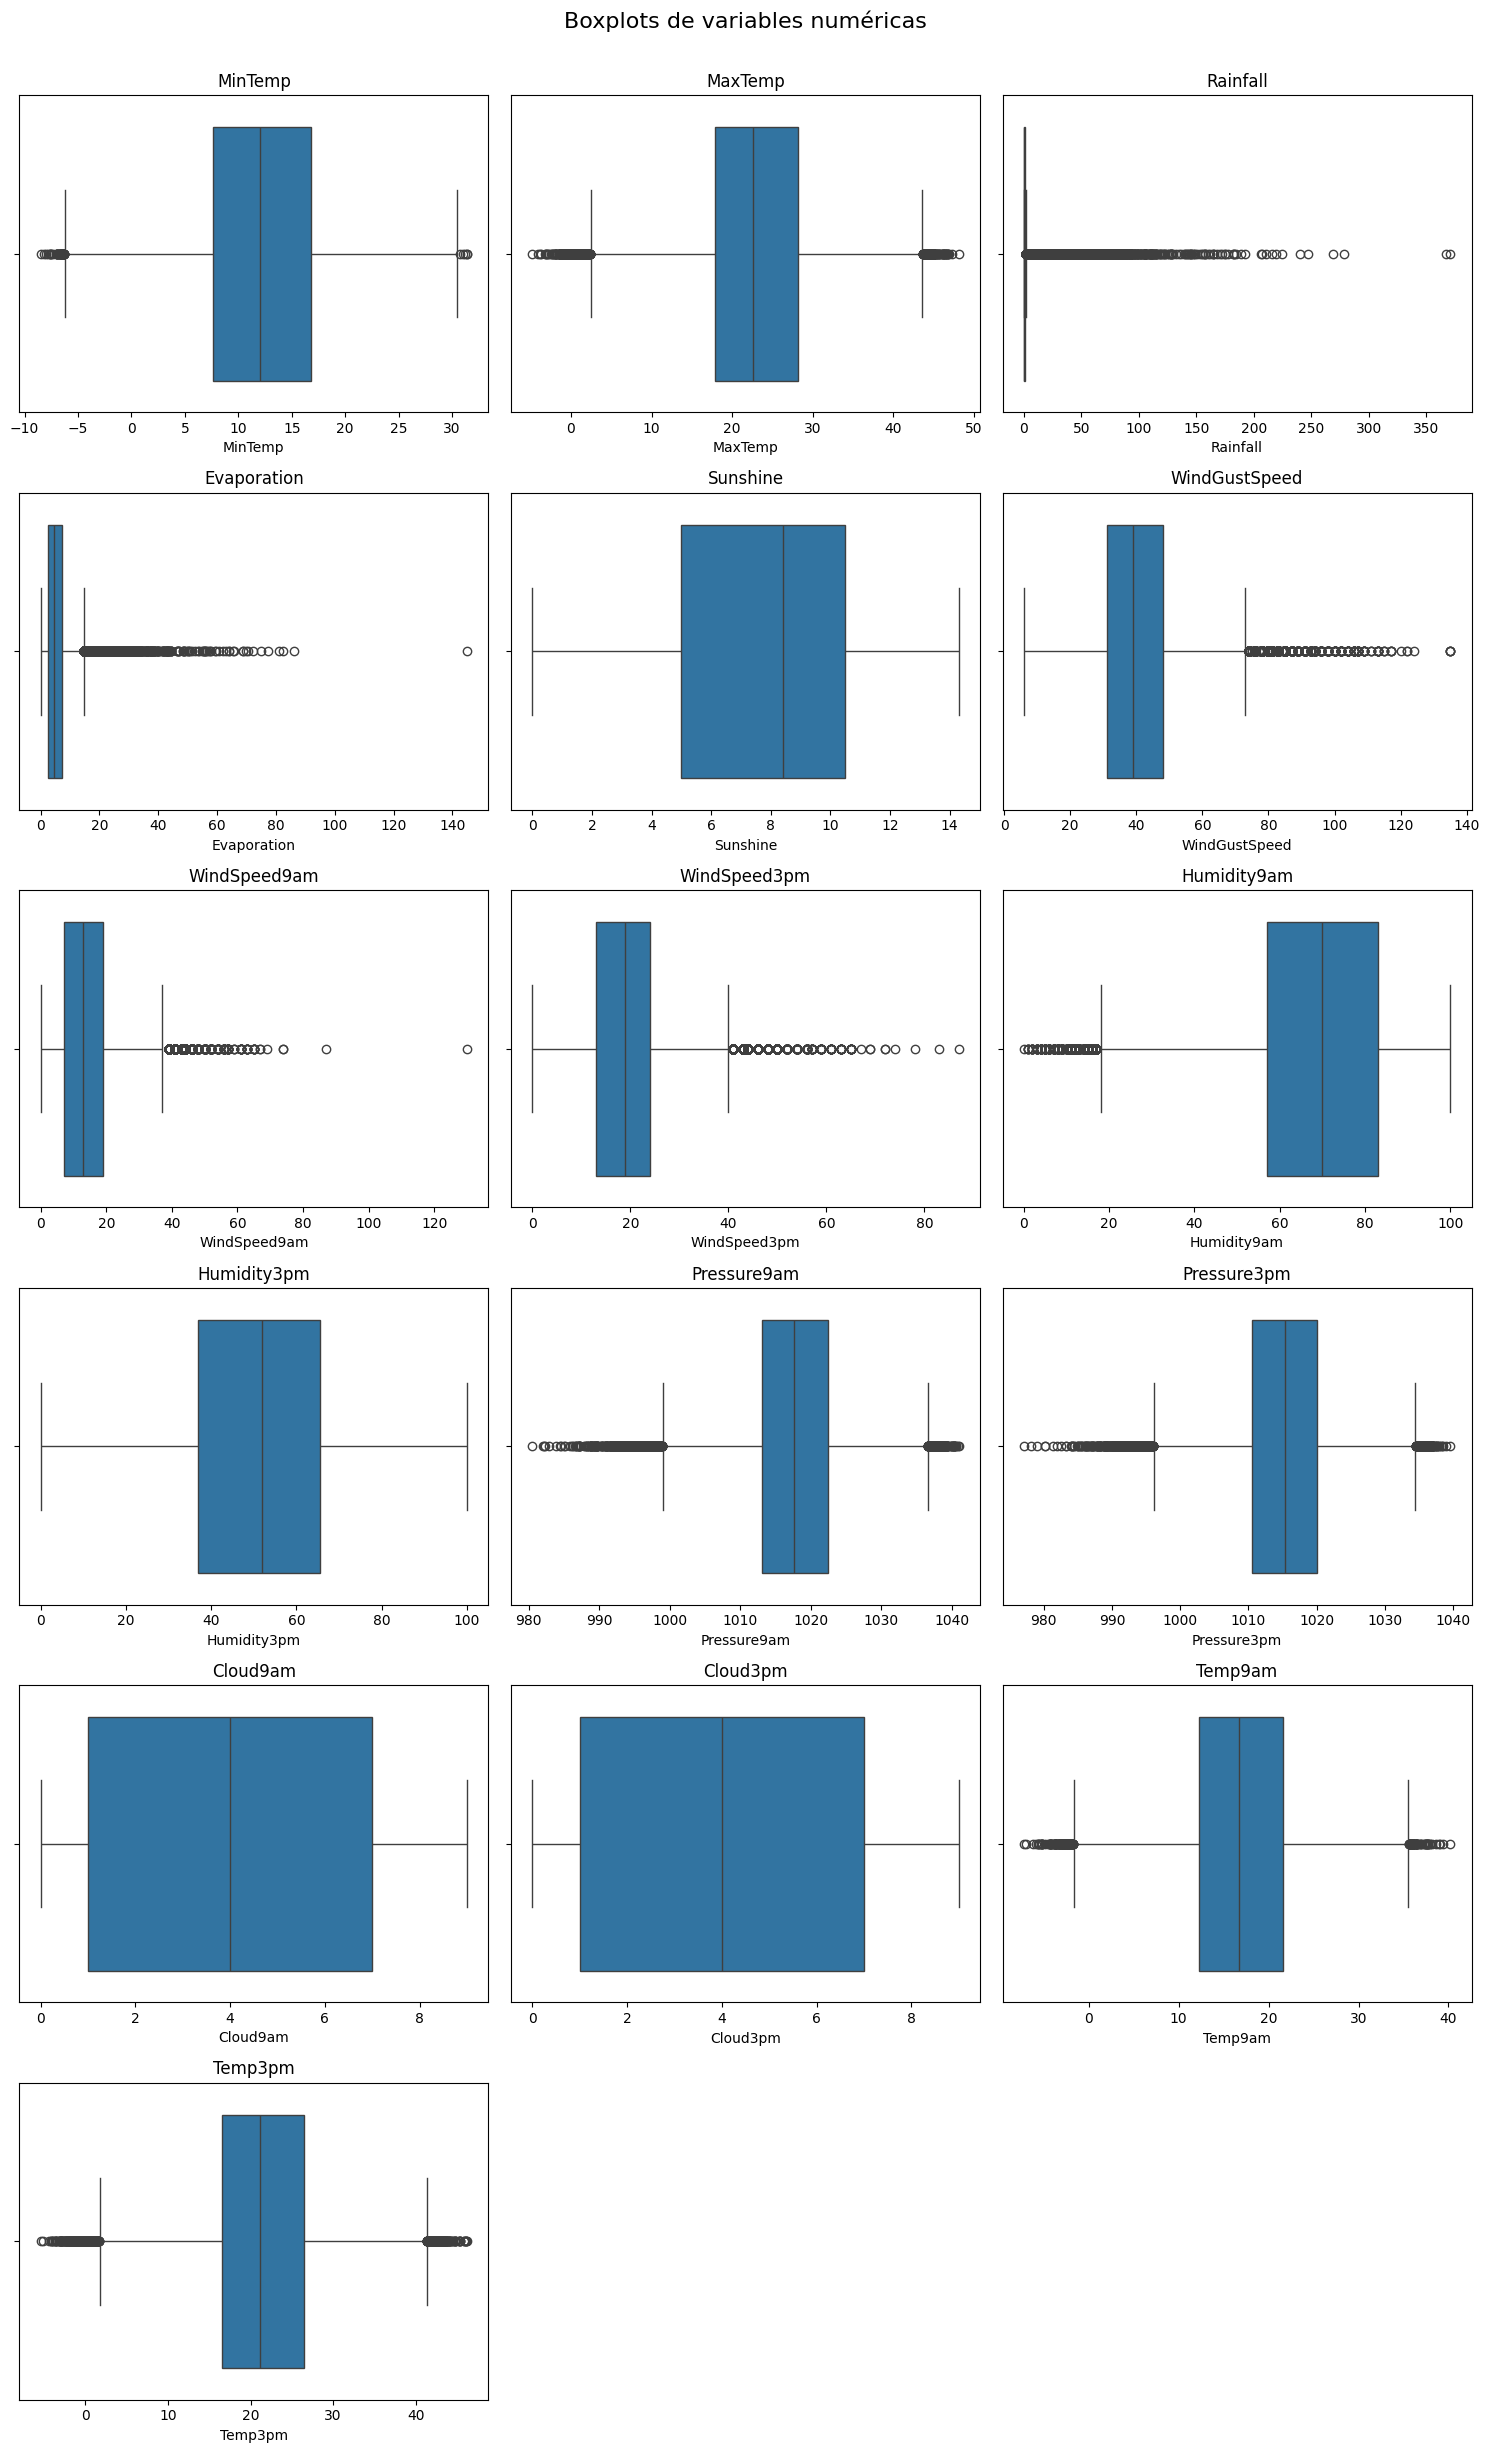

In [43]:
plot_boxplots(X_train, num_cols)

Aplicamos una transformación logarítmica sobre las variables que poseen valores atípicos y una distribución sesgada a la derecha.

In [44]:
# Variables con valores > 0 → aplicar log
vars_log = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

for col in vars_log:
    X_train[col + '_log'] = np.log1p(X_train[col])
    X_test[col + '_log'] = np.log1p(X_test[col])

Transformamos el resto de las variables con valores atípicos, que no tienen un comportamiento exponencial, mediante *capping*. También realizamos la misma transformación sobre las variables a las que le aplicamos transformación logarítmica para comparar resultados más adelante.

In [45]:
def calcular_limites_iqr(X, columnas):
    limites = {}
    for col in columnas:
        q1 = X[col].quantile(0.25)
        q3 = X[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        limites[col] = (lower, upper)
    return limites

def aplicar_capping(X, limites):
    X_capped = X.copy()
    for col, (lower, upper) in limites.items():
        X_capped[col + '_cap'] = np.where(
            X[col] > upper, upper,
            np.where(X[col] < lower, lower, X[col])
        )
    return X_capped

def imprimir_limites(limites):
    print("\nLímites de capping por IQR:")
    for col, (lower, upper) in limites.items():
        print(f"  {col}: Lower = {lower:.2f}, Upper = {upper:.2f}")

In [46]:
# Variables a tratar
vars_cap = ['Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm', 'Humidity9am',
            'MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

# Calcular límites con X_train
limites_iqr = calcular_limites_iqr(X_train, vars_cap)

# Aplicar capping
X_train = aplicar_capping(X_train, limites_iqr)
X_test = aplicar_capping(X_test, limites_iqr)

# Imprimir los límites
imprimir_limites(limites_iqr)


Límites de capping por IQR:
  Temp9am: Lower = -1.65, Upper = 35.55
  Temp3pm: Lower = 1.75, Upper = 41.35
  Pressure9am: Lower = 999.00, Upper = 1036.60
  Pressure3pm: Lower = 996.10, Upper = 1034.50
  Humidity9am: Lower = 18.00, Upper = 122.00
  MinTemp: Lower = -6.20, Upper = 30.60
  MaxTemp: Lower = 2.45, Upper = 43.65
  WindGustSpeed: Lower = 5.50, Upper = 73.50
  WindSpeed9am: Lower = -11.00, Upper = 37.00
  WindSpeed3pm: Lower = -3.50, Upper = 40.50


Debido a la distribución observada en las variables Rainfall y Evaporation, tomamos la desición de categorizarlas.

In [47]:
X_train['Rainfall'].describe(percentiles=[.25, .5, .75])

count    113754.000000
mean          2.359334
std           8.531676
min           0.000000
25%           0.000000
50%           0.000000
75%           0.600000
max         371.000000
Name: Rainfall, dtype: float64

In [48]:
X_train['Rainfall_cat'] = pd.cut(
    X_train['Rainfall'],
    bins=[-float('inf'), 10, 30, float('inf')],
    labels=['bajo', 'medio', 'alto']
)
X_test['Rainfall_cat'] = pd.cut(
    X_test['Rainfall'],
    bins=[-float('inf'), 10, 30, float('inf')],
    labels=['bajo', 'medio', 'alto']
)

In [49]:
X_train['Evaporation'].describe(percentiles=[.25, .5, .75])

count    113754.000000
mean          5.407129
std           3.879473
min           0.000000
25%           2.600000
50%           4.700000
75%           7.400000
max         145.000000
Name: Evaporation, dtype: float64

In [50]:
X_train['Evaporation_cat'] = pd.cut(
    X_train['Evaporation'],
    bins=[-float('inf'), 3, 7, float('inf')],
    labels=['bajo', 'medio', 'alto']
)
X_test['Evaporation_cat'] = pd.cut(
    X_test['Evaporation'],
    bins=[-float('inf'), 3, 7, float('inf')],
    labels=['bajo', 'medio', 'alto']
)

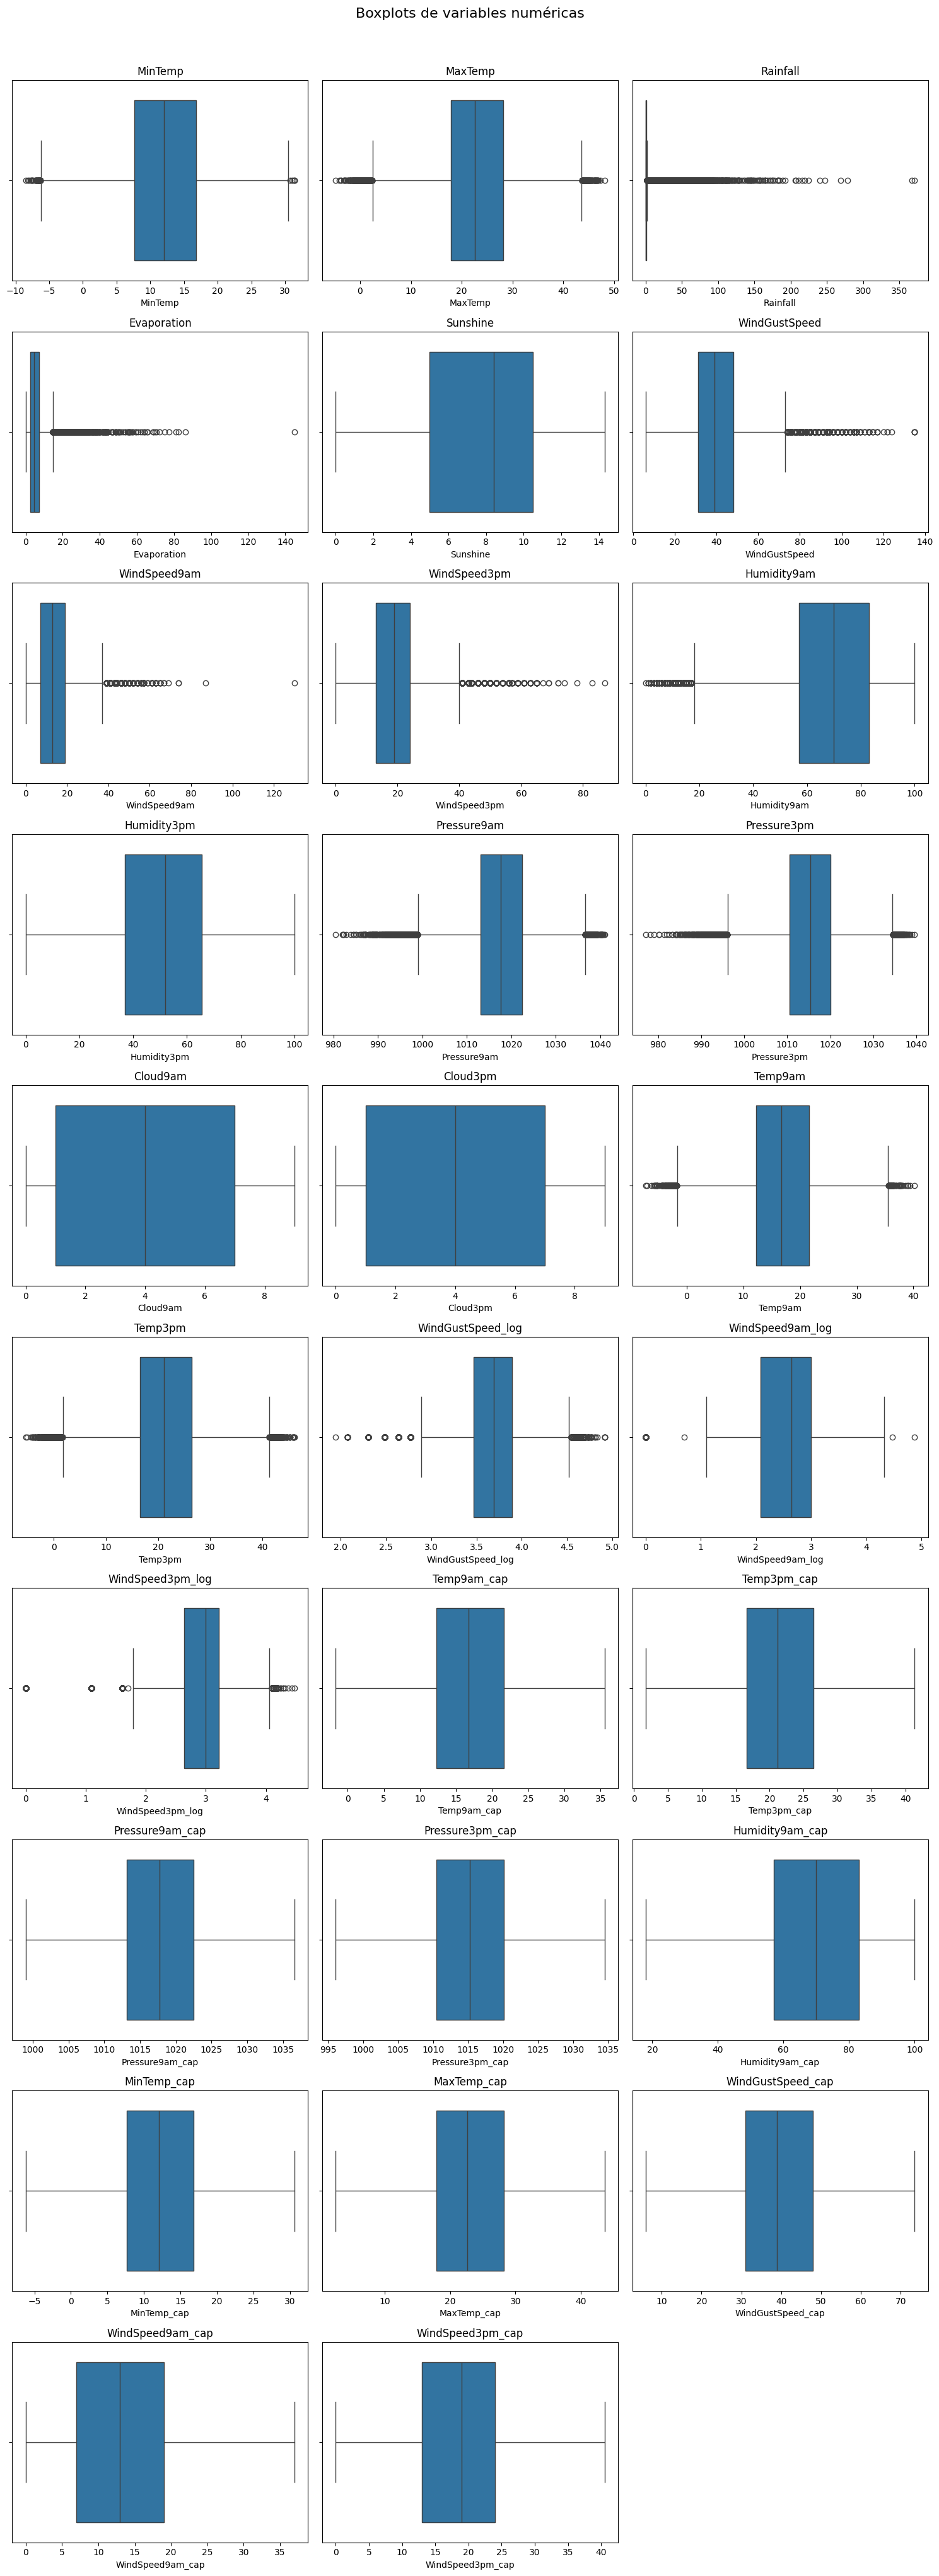

In [51]:
#volvemos a definir num_cols para que incluya las columnas transformadas
num_cols_transf = X_train.select_dtypes(include=['float64', 'int64']).columns
plot_boxplots(X_train, num_cols_transf)

Analizamos la distribución de las variables numéricas luego del tratamiento de outliers.

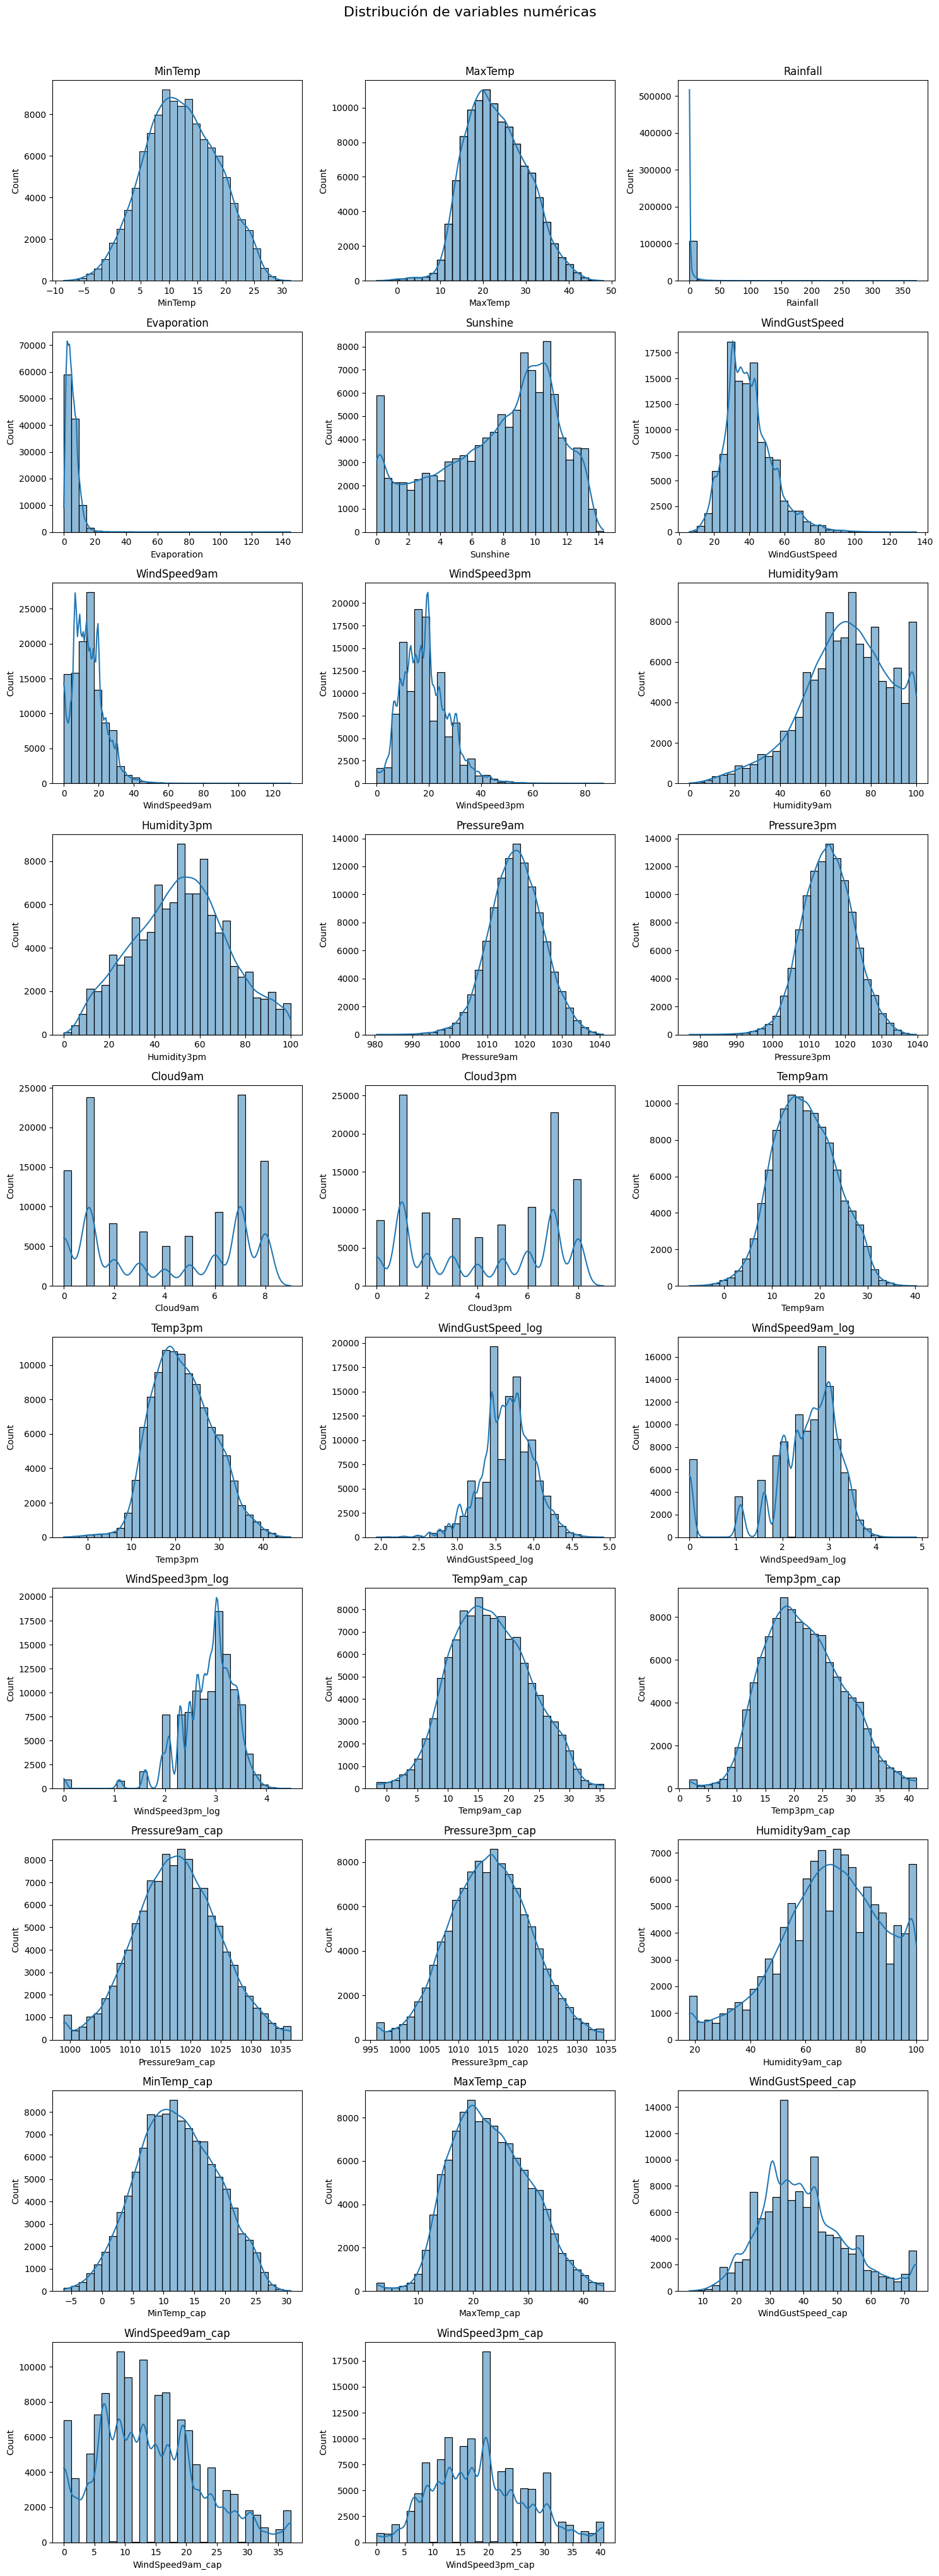

In [52]:
plot_numeric_distributions(X_train, num_cols_transf)

Viendo los gráficos podemos comparar los distintos resultados de aplicar transformaciones a las variables originales y tomar desiciones sobre que variables utilizar para entrenar el modelo.

## Estandarizacion y Codificación

In [53]:
# Mapeo de direcciones a grados
wind_dir_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90,
    'ESE': 112.5, 'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5,
    'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Convertir direcciones a grados a grados
X_train['WindGustDir_degrees'] = X_train['WindGustDir'].map(wind_dir_map)
X_test['WindGustDir_degrees'] = X_test['WindGustDir'].map(wind_dir_map)
X_train['WindDir9am_degrees'] = X_train['WindDir9am'].map(wind_dir_map)
X_test['WindDir9am_degrees'] = X_test['WindDir9am'].map(wind_dir_map)
X_train['WindDir3pm_degrees'] = X_train['WindDir3pm'].map(wind_dir_map)
X_test['WindDir3pm_degrees'] = X_test['WindDir3pm'].map(wind_dir_map)

# Codificación cíclica para WindGustDir
X_train['WindGustDir_sin'] = np.sin(2 * np.pi * X_train['WindGustDir_degrees'] / 360)
X_train['WindGustDir_cos'] = np.cos(2 * np.pi * X_train['WindGustDir_degrees'] / 360)

X_test['WindGustDir_sen'] = np.sin(2 * np.pi * X_test['WindGustDir_degrees'] / 360)
X_test['WindGustDir_cos'] = np.cos(2 * np.pi * X_test['WindGustDir_degrees'] / 360)

# Codificación cíclica para WindDir9am
X_train['WindDir9am_sin'] = np.sin(2 * np.pi * X_train['WindDir9am_degrees'] / 360)
X_train['WindDir9am_cos'] = np.cos(2 * np.pi * X_train['WindDir9am_degrees'] / 360)

X_test['WindDir9am_sin'] = np.sin(2 * np.pi * X_test['WindDir9am_degrees'] / 360)
X_test['WindDir9am_cos'] = np.cos(2 * np.pi * X_test['WindDir9am_degrees'] / 360)

# Codificación cíclica para WindDir3pm
X_train['WindDir3pm_sin'] = np.sin(2 * np.pi * X_train['WindDir3pm_degrees'] / 360)
X_train['WindDir3pm_cos'] = np.cos(2 * np.pi * X_train['WindDir3pm_degrees'] / 360)

X_test['WindDir3pm_sin'] = np.sin(2 * np.pi * X_test['WindDir3pm_degrees'] / 360)
X_test['WindDir3pm_cos'] = np.cos(2 * np.pi * X_test['WindDir3pm_degrees'] / 360)

# Codificación cíclica para mes
X_train['mes_sin'] = np.sin(2 * np.pi * X_train['mes'] / 12)
X_train['mes_cos'] = np.cos(2 * np.pi * X_train['mes'] / 12)

X_test['mes_sin'] = np.sin(2 * np.pi * X_test['mes'] / 12)
X_test['mes_cos'] = np.cos(2 * np.pi * X_test['mes'] / 12)

In [54]:
# One Hot Encoding a otras variables categóricas
encoder = ce.OneHotEncoder(cols=['Rainfall_cat', 'Evaporation_cat','RegionCluster'], use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [55]:
# Binary Encoder para "RainToday"
encoder = ce.BinaryEncoder(cols=['RainToday'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

Observamos la información de las variables resultantes.

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113754 entries, 0 to 113753
Data columns (total 63 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   MinTemp                113754 non-null  float64
 1   MaxTemp                113754 non-null  float64
 2   Rainfall               113754 non-null  float64
 3   Evaporation            113754 non-null  float64
 4   Sunshine               113754 non-null  float64
 5   WindGustDir            113754 non-null  object 
 6   WindGustSpeed          113754 non-null  float64
 7   WindDir9am             113754 non-null  object 
 8   WindDir3pm             113754 non-null  object 
 9   WindSpeed9am           113754 non-null  float64
 10  WindSpeed3pm           113754 non-null  float64
 11  Humidity9am            113754 non-null  float64
 12  Humidity3pm            113754 non-null  float64
 13  Pressure9am            113754 non-null  float64
 14  Pressure3pm            113754 non-nu

Eliminamos las variables que no va a utilizar el modelo.

In [57]:
X_train.drop(columns=['WindGustDir_degrees','WindGustDir','WindDir9am','WindDir9am_degrees','WindDir3pm','WindDir3pm_degrees', 'mes',
                      'Evaporation', 'Rainfall', 'fecha', 'MinTemp', 'MaxTemp','WindGustSpeed','WindSpeed9am',
                      'WindSpeed3pm', 'Humidity9am','Pressure9am','Pressure3pm','Temp9am','Temp3pm', 'WindGustSpeed_log',
                      'WindSpeed9am_log', 'WindSpeed3pm_log'], inplace=True)
X_test.drop(columns=['WindGustDir_degrees','WindGustDir','WindDir9am','WindDir9am_degrees','WindDir3pm','WindDir3pm_degrees', 'mes',
                      'Evaporation', 'Rainfall', 'fecha', 'MinTemp', 'MaxTemp','WindGustSpeed','WindSpeed9am',
                      'WindSpeed3pm', 'Humidity9am','Pressure9am','Pressure3pm','Temp9am','Temp3pm', 'WindGustSpeed_log',
                      'WindSpeed9am_log', 'WindSpeed3pm_log'], inplace=True)

In [58]:
# Redefinimos nuestras columnas numéricas para realizar el escalado posterior
# Columnas numéricas
num_cols =  [col for col in X_train.columns if col not in ['RainToday_0', 'RainToday_1', 'mes_sin', 'mes_cos',
                                                           'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
                                                           'WindDir9am_cos', 'WindDir3pm_sin','WindDir3pm_cos', 'Rainfall_cat_bajo',
                                                           'Rainfall_cat_medio','Rainfall_cat_alto', 'Evaporation_cat_bajo',
                                                           'Evaporation_cat_medio', 'Evaporation_cat_alto', 'RegionCluster_0.0',
                                                           'RegionCluster_1.0','RegionCluster_2.0','RegionCluster_3.0','RegionCluster_4.0',
                                                           'RegionCluster_5.0','RegionCluster_6.0', 'RegionCluster_7.0', 'RegionCluster_8.0']]


In [59]:
print(num_cols)

['Sunshine', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'anio', 'Temp9am_cap', 'Temp3pm_cap', 'Pressure9am_cap', 'Pressure3pm_cap', 'Humidity9am_cap', 'MinTemp_cap', 'MaxTemp_cap', 'WindGustSpeed_cap', 'WindSpeed9am_cap', 'WindSpeed3pm_cap']


Realizamos el escalado de las variables numéricas.

In [60]:
preprocesador = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('scaler', StandardScaler())
    ]), num_cols)
])

# Modelado

Chequeamos los datos finales con los que entrenaremos nuestro modelo.

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113754 entries, 0 to 113753
Data columns (total 40 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Sunshine               113754 non-null  float64
 1   Humidity3pm            113754 non-null  float64
 2   Cloud9am               113754 non-null  float64
 3   Cloud3pm               113754 non-null  float64
 4   RainToday_0            113754 non-null  int64  
 5   RainToday_1            113754 non-null  int64  
 6   anio                   113754 non-null  int32  
 7   RegionCluster_6.0      113754 non-null  int64  
 8   RegionCluster_1.0      113754 non-null  int64  
 9   RegionCluster_0.0      113754 non-null  int64  
 10  RegionCluster_3.0      113754 non-null  int64  
 11  RegionCluster_4.0      113754 non-null  int64  
 12  RegionCluster_8.0      113754 non-null  int64  
 13  RegionCluster_2.0      113754 non-null  int64  
 14  RegionCluster_5.0      113754 non-nu

In [62]:
X_test.isnull().sum()

Sunshine                 0
Humidity3pm              0
Cloud9am                 0
Cloud3pm                 0
RainToday_0              0
RainToday_1              0
anio                     0
RegionCluster_6.0        0
RegionCluster_1.0        0
RegionCluster_0.0        0
RegionCluster_3.0        0
RegionCluster_4.0        0
RegionCluster_8.0        0
RegionCluster_2.0        0
RegionCluster_5.0        0
RegionCluster_7.0        0
Temp9am_cap              0
Temp3pm_cap              0
Pressure9am_cap          0
Pressure3pm_cap          0
Humidity9am_cap          0
MinTemp_cap              0
MaxTemp_cap              0
WindGustSpeed_cap        0
WindSpeed9am_cap         0
WindSpeed3pm_cap         0
Rainfall_cat_bajo        0
Rainfall_cat_medio       0
Rainfall_cat_alto        0
Evaporation_cat_bajo     0
Evaporation_cat_medio    0
Evaporation_cat_alto     0
WindGustDir_sen          0
WindGustDir_cos          0
WindDir9am_sin           0
WindDir9am_cos           0
WindDir3pm_sin           0
W

Realizamos el modelado con **Regresión Logística**

In [63]:
# Creación del pipeline con el modelo de regresion lineal

pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('model',  LogisticRegression(random_state=42))
])

# Fitteo y prediccion del modelo
pipeline.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)


In [64]:
print(y_pred)

[0 0 0 ... 0 1 0]


# Evaluación del modelo

Realizamos la matriz de confusión.

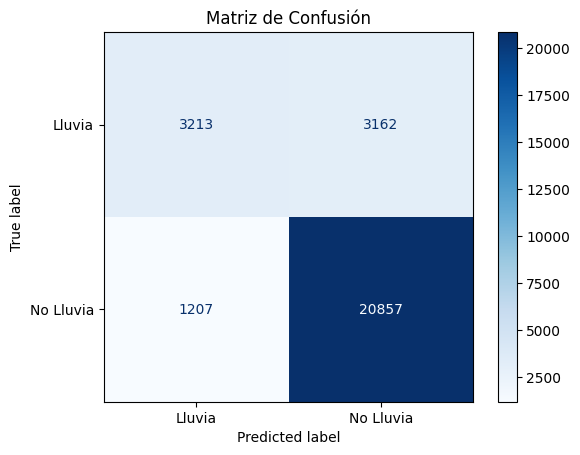

In [65]:
# Probabilidades para clase 1 (lluvia)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Asumiendo que 1 = lluvia (clase positiva)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Lluvia', 'No Lluvia'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

## Métricas

Dado que nuestros datos se encuentran desbalanceados descartamos la posibilidad de aplicar Accuracy. Utilizaremos las métricas de Recall, Precisión y F1 como combinación de ellas para evaluar ambas clases. Específicamente buscaremos minimizar los FN, es decir, la predicción de que no llovía cuando sí llovió. Para esto, le daremos mayor importancia a la métrica de Recall de la clase 1 (Sí llovió) que representa cuantos de los días en los que si llovió fueron detectados correctamente por la predicción del modelo.


In [66]:
# Métricas de evaluación
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"\n Métricas del modelo:")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}  ← Buscamos maximizarla, por importancia de los FN")
print(f"F1-score : {f1:.2f}")


print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Lluvia', 'Lluvia']))



 Métricas del modelo:
Precision: 0.73
Recall   : 0.50  ← Buscamos maximizarla, por importancia de los FN
F1-score : 0.60

 Reporte de clasificación:
              precision    recall  f1-score   support

   No Lluvia       0.87      0.95      0.91     22064
      Lluvia       0.73      0.50      0.60      6375

    accuracy                           0.85     28439
   macro avg       0.80      0.72      0.75     28439
weighted avg       0.84      0.85      0.84     28439



Calculamos las métricas de entrenamiento para analizar el fitting del modelo.

In [67]:
y_pred_train = pipeline.predict(X_train)
# Métricas de evaluación
precision = precision_score(y_train, y_pred_train, pos_label=1)
recall = recall_score(y_train, y_pred_train, pos_label=1)
f1 = f1_score(y_train, y_pred_train, pos_label=1)

print(f"\n Métricas del modelo (para los datos de entrenamiento):")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}  ← Buscamos maximizarla, por importancia de los FN")
print(f"F1-score : {f1:.2f}")


print("\n Reporte de clasificación:")
print(classification_report(y_train, y_pred_train, target_names=['No Lluvia', 'Lluvia']))


 Métricas del modelo (para los datos de entrenamiento):
Precision: 0.72
Recall   : 0.51  ← Buscamos maximizarla, por importancia de los FN
F1-score : 0.60

 Reporte de clasificación:
              precision    recall  f1-score   support

   No Lluvia       0.87      0.94      0.90     88252
      Lluvia       0.72      0.51      0.60     25502

    accuracy                           0.85    113754
   macro avg       0.79      0.73      0.75    113754
weighted avg       0.84      0.85      0.84    113754



Notamos que las métricas son similares en train y test por lo tanto deducimos que no hay Overfitting.

Probamos con un umbral menor (0.3) con el objetivo de aumentar el recall de la clase 1 (lluvia).

In [68]:
# Elegir un nuevo umbral
umbral = 0.3

# Aplicar el nuevo umbral para obtener las predicciones ajustadas
y_pred_umbral = (y_scores >= umbral).astype(int)


In [69]:
# Métricas con nuevo umbral
print(confusion_matrix(y_test, y_pred_umbral))
print(classification_report(y_test, y_pred_umbral, target_names=['No Lluvia', 'Lluvia']))

[[18944  3120]
 [ 1922  4453]]
              precision    recall  f1-score   support

   No Lluvia       0.91      0.86      0.88     22064
      Lluvia       0.59      0.70      0.64      6375

    accuracy                           0.82     28439
   macro avg       0.75      0.78      0.76     28439
weighted avg       0.84      0.82      0.83     28439



Podemos observar como mejora el recall de la clase 1 como también disminuye la precisión.

## Curva ROC

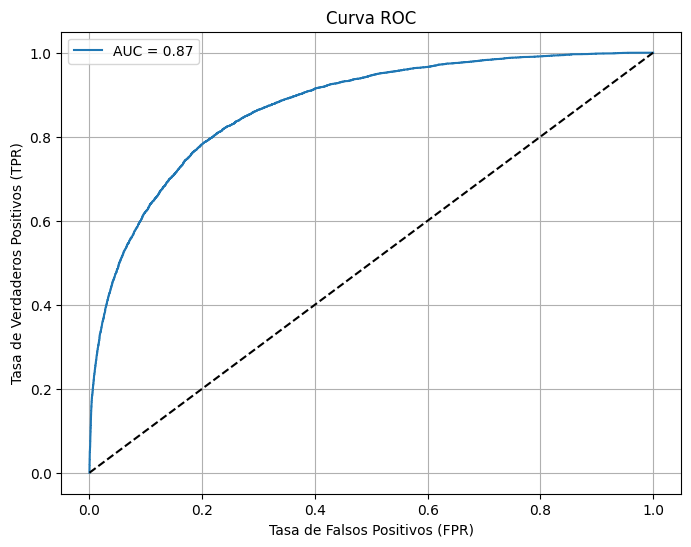

In [70]:
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_scores):.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Probamos con el umbral óptimo, obtenido del punto de la curva ROC más cercano al vértice superior izquierdo, con el objetivo de equilibrar la tasa de verdaderos positivos y falsos positivos.

In [71]:
# y_scores  son las probabilidades para clase 1
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calcular distancia al punto (0,1) para cada umbral
distancias = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Índice del umbral óptimo
idx_optimo = np.argmin(distancias)

# Umbral óptimo
umbral_optimo = thresholds[idx_optimo]

print(f" Umbral óptimo según curva ROC: {umbral_optimo:.2f}")

 Umbral óptimo según curva ROC: 0.22


In [72]:
# Aplicar el umbral óptimo
y_pred_optimo = (y_scores >= umbral_optimo).astype(int)

# Evaluar desempeño
print(confusion_matrix(y_test, y_pred_optimo))
print(classification_report(y_test, y_pred_optimo, target_names=['No Lluvia', 'Lluvia']))


[[17562  4502]
 [ 1357  5018]]
              precision    recall  f1-score   support

   No Lluvia       0.93      0.80      0.86     22064
      Lluvia       0.53      0.79      0.63      6375

    accuracy                           0.79     28439
   macro avg       0.73      0.79      0.74     28439
weighted avg       0.84      0.79      0.81     28439



Podemos observar que mejora el recall de la clase 1 (Lluvia) y la precision de la clase 0 (No Lluvia).

Probamos disminuyendo el umbral a 0.2 para aumentaron el Recall de la clase 1.

In [73]:
# Elegir un nuevo umbral
umbral = 0.20

# Aplicar el nuevo umbral para obtener las predicciones ajustadas
y_pred_umbral = (y_scores >= umbral).astype(int)

In [74]:
# Métricas con nuevo umbral
print(confusion_matrix(y_test, y_pred_umbral))
print(classification_report(y_test, y_pred_umbral, target_names=['No Lluvia', 'Lluvia']))

[[17002  5062]
 [ 1206  5169]]
              precision    recall  f1-score   support

   No Lluvia       0.93      0.77      0.84     22064
      Lluvia       0.51      0.81      0.62      6375

    accuracy                           0.78     28439
   macro avg       0.72      0.79      0.73     28439
weighted avg       0.84      0.78      0.79     28439



# Tratamiento de desbalanceo

Observamos cómo es la distribución de nuestros datos según la clase.

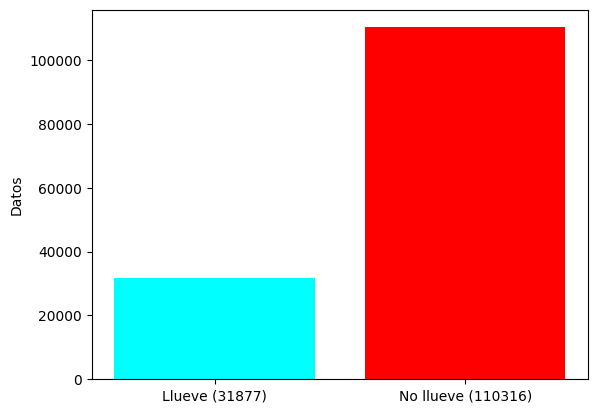

In [75]:
llueve = len(y[y == 1])
no_llueve = len(y[y == 0])

plt.bar(["Llueve (%d)" % llueve, "No llueve (%d)" % no_llueve],
        [llueve, no_llueve],
        color =["cyan", "red"],
        width = 0.8)
plt.ylabel("Datos")
plt.show()

Se observa un gran desbalanceo que puede ocasionar inconvenientes en las predicciones.

In [76]:
pipeline_balanceado = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('model',  LogisticRegression(random_state=42, class_weight='balanced'))
])

# Fitteo y prediccion del modelo
pipeline_balanceado.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_balanceado = pipeline_balanceado.predict(X_test)

# Obtengo las probabilidades de predicción del modelo
y_probs_balanceado = pipeline_balanceado.predict_proba(X_test)[:, 0]

# Evaluar (Lo agreuge de abajo sino no daba resultados)
print("Resultados regresión logística con balanceo:\n")
print(classification_report(y_test, y_pred_balanceado))

Resultados regresión logística con balanceo:

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.53      0.78      0.63      6375

    accuracy                           0.79     28439
   macro avg       0.73      0.79      0.74     28439
weighted avg       0.84      0.79      0.81     28439



## Oversampling

Remuestreo con oversampling

In [77]:
# Crear el pipeline completo con preprocesamiento y oversampling
pipeline_oversampled = ImbPipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('oversample', RandomOverSampler(random_state=42)),
    ('modelo', LogisticRegression(random_state=42))
])

# Entrenar con el pipeline
pipeline_oversampled.fit(X_train, y_train)

# Predecir
y_pred = pipeline_oversampled.predict(X_test)

# Evaluar
print("Resultados regresión logística con Oversampling:\n")
print(classification_report(y_test, y_pred))


Resultados regresión logística con Oversampling:

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.53      0.78      0.63      6375

    accuracy                           0.79     28439
   macro avg       0.73      0.79      0.74     28439
weighted avg       0.84      0.79      0.81     28439



## Smote

In [78]:
# Pipeline completo con preprocesamiento y SMOTE
pipeline_smote = ImbPipeline(steps=[
    ('preprocesamiento', preprocesador),   # tu ColumnTransformer con OneHotEncoder y StandardScaler
    ('smote', SMOTE(random_state=42)),     # aplica SMOTE después del preprocesamiento
    ('modelo', LogisticRegression(random_state=42))
])

# Entrenar el pipeline
pipeline_smote.fit(X_train, y_train)

# Predecir sobre el test (se preprocesa igual que el train)
y_pred_smote = pipeline_smote.predict(X_test)

# Evaluar
print("Resultados regresión logística con SMOTE:\n")
print(classification_report(y_test, y_pred_smote))


Resultados regresión logística con SMOTE:

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.53      0.78      0.63      6375

    accuracy                           0.80     28439
   macro avg       0.73      0.79      0.75     28439
weighted avg       0.84      0.80      0.81     28439



## Comparación de matrices de confusion

In [79]:
def matriz_de_confusion(clases_reales, clases_predichas, titulo):
    """ Visualiza la matriz de confusión con F1 Score """
    matriz = confusion_matrix(clases_reales, clases_predichas)
    f1 = f1_score(clases_reales, clases_predichas)

    matriz = pd.DataFrame(matriz,
                          columns=["0 : No llueve", "1 : Llueve"],
                          index=["0 : No llueve", "1 : Llueve"])

    plt.figure(figsize=(4, 4))
    plt.matshow(matriz.values, cmap="Blues", vmin=0, vmax=20000)
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.index)), matriz.index)

    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))

    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, f"F1 Score: {f1:.2f}", fontsize=15, color="blue")

    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[j, i]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[j][i],
                     fontsize=11.5, ha="center", va="center")
    plt.show()

<Figure size 400x400 with 0 Axes>

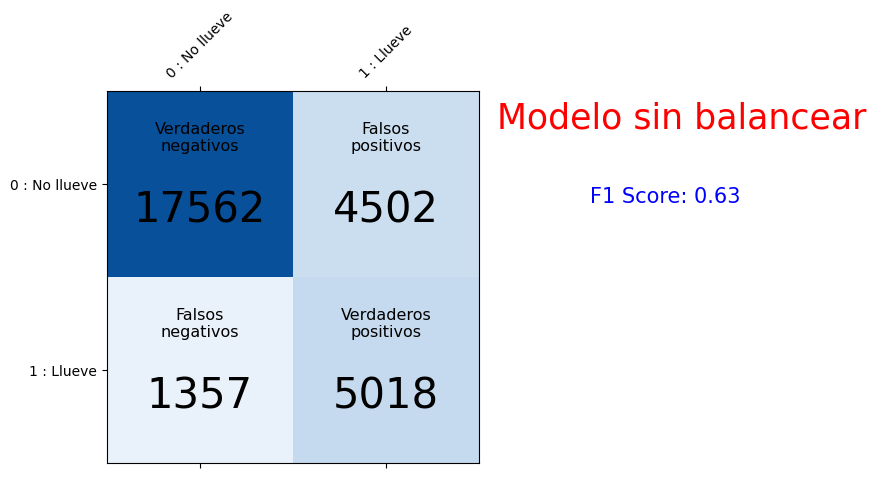

In [80]:
matriz_de_confusion(y_test, y_pred_optimo, "Modelo sin balancear")

<Figure size 400x400 with 0 Axes>

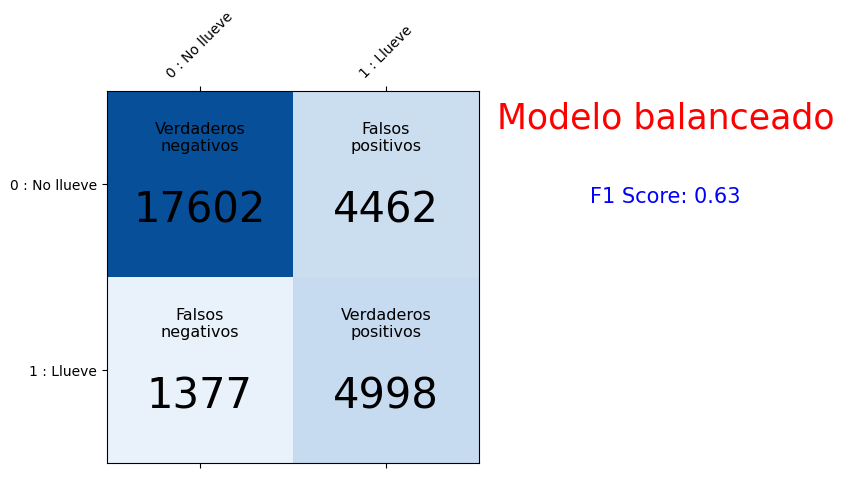

In [81]:
matriz_de_confusion(y_test, y_pred_balanceado, "Modelo balanceado")

<Figure size 400x400 with 0 Axes>

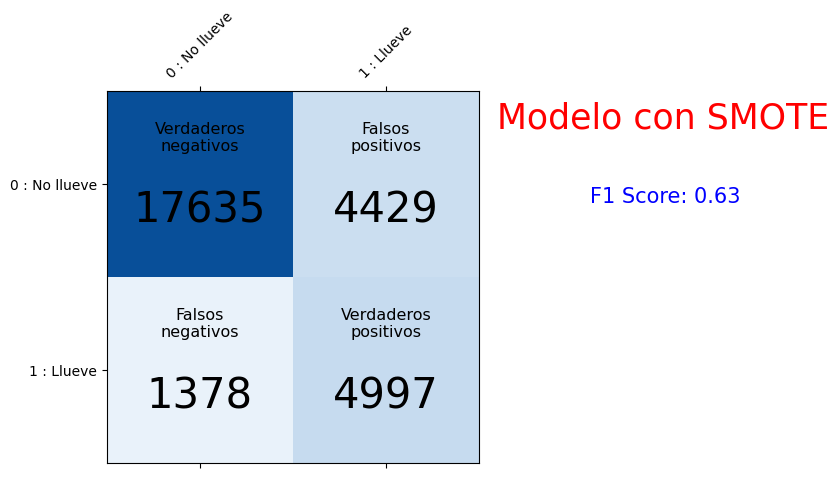

In [82]:
matriz_de_confusion(y_test, y_pred_smote, "Modelo con SMOTE")

De los resultados de los distintos balanceos aplicados podemos observar que no se producen mejoras en las métricas obtenidas.
Notamos que obtuvimos un mejor desempeño en las métricas en el modelo original ajustando el umbral de decisión al óptimo establecido por la curva ROC.